In [1]:
import h5py
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from scipy import signal
from scipy.fft import fftshift

In [7]:
# Get modulation settings from file generated at the time of data collection
modulations = ["BPSK", "QPSK", "8PSK", "16QAM", "64QAM", "PAM4", "GFSK", "CPFSK", "B-FM", "DSB-AM", "SSB-AM"]
# modulations = ["BPSK", "QPSK", "8PSK", "16QAM", "64QAM", "PAM4", "GFSK", "CPFSK"]
# Get TX and RX settings from a file generated at the time of data collection
TXs = [1]
RXs = [3,4,5,6]
# Get date from file generated at the time of data collection
date = str(20250310) #"20241107"
# Add file with 
folder = "/Users/josea/Workspaces/siwn/data"
centralizedDataFileName = "Node_TX_"+"".join([str(tx)+"_" for tx in TXs])+"RX_"+"".join([str(rx)+"_" for rx in RXs])+str(len(modulations))+"Modulations_"+date
print(centralizedDataFileName)
centralizedDataFile = h5py.File(folder+"/nodes/"+centralizedDataFileName+".h5", "w")
all_data = []
all_labels = []
for TX in TXs:
    Node_Data = {RX:[] for RX in RXs}
    Node_Labels = {RX:[] for RX in RXs}
    print(Node_Data)
    print(Node_Labels)
    dataModulation = {}
    labelsModulation = {}
    N = 0
    for modulation in modulations:
        fileName = modulation+"_"+str(TX)+"_TX_"+"".join([str(rx)+"_" for rx in RXs])+"RX_"+date
        with h5py.File(folder+"/"+fileName+'.h5', 'r') as f:
            # Load the data and labels datasets.
            dataModulation[modulation] = f['data'][:]
            print(dataModulation[modulation].shape)
            labelsModulation[modulation] = f['node'][:]
            print(labelsModulation[modulation].shape)
        
        for i in range(len(dataModulation[modulation])):
            Node_Data[labelsModulation[modulation][i]].append(dataModulation[modulation][i])
            Node_Labels[labelsModulation[modulation][i]].append(N)
        
        N = N+1
    
    # print(Node_Data[0][0].shape)
    # print(Node_Labels[0][-1])
    for node in Node_Data:
        filename = "Node_TX_"+str(TX)+"_RX_"+str(node)+"_"+str(len(modulations))+"Modulations_"+date
        file = h5py.File(folder+"/nodes/"+filename+".h5", "w")
        # Create datasets within the HDF5 file
        all_data.append(Node_Data[node])
        all_labels.append(Node_Labels[node])
        file.create_dataset("data", data=Node_Data[node])
        file.create_dataset("labels", data=Node_Labels[node])
        file.close()

all_data = np.concatenate(all_data, axis=0)  # Concatenate along rows
all_labels = np.concatenate(all_labels, axis=0)
centralizedDataFile.create_dataset("data", data=all_data)
centralizedDataFile.create_dataset("labels", data=all_labels)
centralizedDataFile.close()


Node_TX_1_RX_3_4_5_6_11Modulations_20250310
{3: [], 4: [], 5: [], 6: []}
{3: [], 4: [], 5: [], 6: []}
(40000, 2, 1024)
(40000,)
(40000, 2, 1024)
(40000,)
(40000, 2, 1024)
(40000,)
(40000, 2, 1024)
(40000,)
(40000, 2, 1024)
(40000,)
(40000, 2, 1024)
(40000,)
(40000, 2, 1024)
(40000,)
(40000, 2, 1024)
(40000,)
(40000, 2, 1024)
(40000,)
(40000, 2, 1024)
(40000,)
(40000, 2, 1024)
(40000,)


Node_TX_1_RX_2_3_11Modulations_20241107


In [103]:
def plotTimeDomain(I,Q,samples=-1,id=0):
    plt.plot(I[0:samples], color='red')
    plt.plot(Q[0:samples], color='blue')
    plt.xlabel('Time')
    plt.ylabel('IQ')
    plt.title('Time Domain Plot Node: '+str(id))
    plt.grid(True)
    plt.axhline(0, color='black',linewidth=0.5)
    plt.axvline(0, color='black',linewidth=0.5)
    plt.show()

def plotConstellationDiagram(I,Q,samples=-1,id=0):
    plt.scatter(I[0:samples], Q[0:samples], color='red')
    plt.xlabel('I')
    plt.ylabel('Q')
    plt.title('Constellation Diagram Plot Node: '+str(id))
    plt.grid(True)
    plt.axhline(0, color='black',linewidth=0.5)
    plt.axvline(0, color='black',linewidth=0.5)
    plt.show()

def plotSpectrogram(I,Q,fs,samples=-1,id=0):
    # x = np.array([complex(Q[i],I[i]) for i in range(len(I))])
    x = np.array(I)+np.array(Q)*1j
    # Short-time Fourier transform (STFT).
    fftLengths = [32, 64, 128, 256, 512]
    for win_len in fftLengths:
        # win_len = fft_len = 512/2
        overlap=win_len//4
        f, t, Sxx = signal.spectrogram(x, fs, window='hann', nperseg=win_len, noverlap=overlap)
        # f, t, Sxx = signal.spectrogram(x, fs, window='hann')
        # f, t, Sxx = signal.stft(x, 
        #                         window='hann', #boxcar, hann, 
        #                         nperseg= win_len, 
        #                         noverlap= overlap, 
        #                         nfft= None,
        #                         return_onesided=False, 
        #                         padded = False, 
        #                         boundary = None)
        # FFT shift to adjust the central frequency.
        # Sxx = np.fft.fftshift(Sxx, axes=0)    
        # Take the logarithm of the magnitude.      
        # Sxx = np.log10(np.abs(Sxx)**2)
        Sxx = Sxx.T
        print(Sxx)
        print(Sxx.shape)
        
        plt.title('Spectrogram Plot Node: '+str(id))
        plt.pcolormesh(f, t, Sxx, shading='gouraud')
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('Time [sec]')
        plt.show()

(11000, 2, 1024)


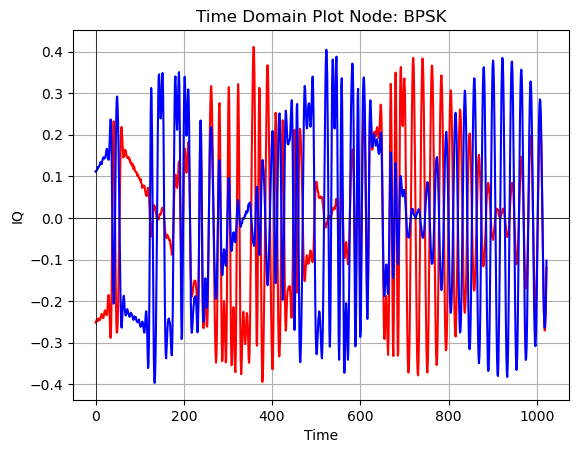

[[1.18988355e-13 3.09375955e-13 2.67790432e-14 ... 6.84248136e-15
  3.69962582e-14 1.04982338e-12]
 [4.53033831e-11 1.66714687e-10 2.64454025e-10 ... 1.17768461e-10
  2.65795652e-10 1.31603172e-10]
 [9.29994506e-11 4.42154511e-11 7.06507283e-12 ... 8.99880952e-12
  6.35944186e-12 6.85735860e-11]
 ...
 [1.09525805e-10 3.33979842e-10 2.35504735e-10 ... 1.23646492e-11
  2.66434115e-10 3.04982744e-10]
 [1.98419960e-10 3.86725066e-10 2.42866596e-10 ... 1.28023443e-11
  2.70155780e-10 3.53975239e-10]
 [8.46842798e-11 3.24203253e-10 2.32466883e-10 ... 1.33585759e-11
  2.62113957e-10 2.90983569e-10]]
(42, 32)


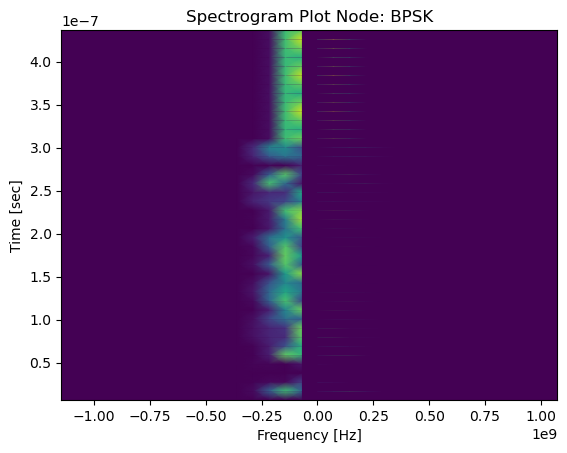

[[3.15643684e-11 5.73868752e-11 7.11961106e-11 ... 9.86922363e-11
  7.61393828e-11 1.23488433e-10]
 [6.36572644e-11 6.05660441e-12 5.63015851e-13 ... 1.18770651e-13
  2.68770316e-13 4.58898596e-11]
 [2.19097479e-12 5.98517375e-11 5.81140483e-11 ... 2.90329892e-10
  1.92944097e-11 1.42794016e-10]
 ...
 [2.55737941e-12 8.73506009e-14 2.13077415e-10 ... 6.81478015e-10
  1.30575901e-10 1.18408818e-13]
 [6.36995650e-15 1.64660323e-13 2.16282006e-10 ... 6.93951818e-10
  1.33950908e-10 4.50488604e-14]
 [2.38116000e-12 5.24211191e-14 2.14701761e-10 ... 6.84668535e-10
  1.31403980e-10 1.21353178e-13]]
(21, 64)


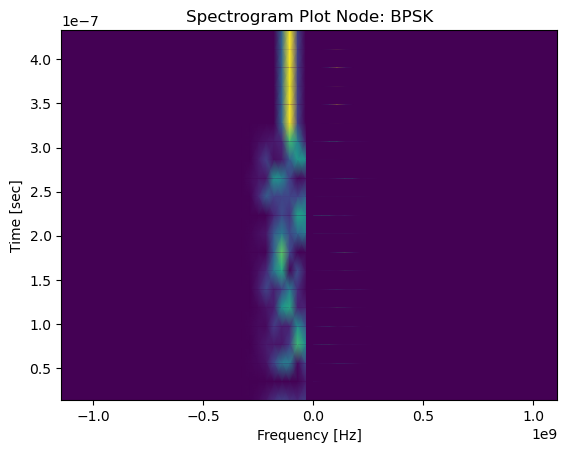

[[1.82388551e-10 4.80920788e-10 1.36513340e-10 ... 4.02679005e-11
  3.03154472e-10 1.02057577e-09]
 [4.14006129e-11 2.55486249e-12 3.13179776e-10 ... 5.17818612e-10
  1.70566858e-10 4.31502473e-11]
 [1.41277191e-11 6.37905161e-11 1.13724625e-10 ... 4.12506648e-11
  9.21157228e-11 3.96371765e-12]
 ...
 [2.05907354e-12 2.75115629e-12 3.40653287e-12 ... 3.29756167e-12
  2.57158520e-12 5.86840460e-12]
 [4.02359387e-12 8.72930420e-13 3.49896822e-14 ... 3.76445258e-14
  4.76275850e-15 7.38641445e-13]
 [3.67310254e-12 6.25129952e-13 1.09768142e-14 ... 3.87921184e-14
  1.85343783e-14 8.09102811e-13]]
(10, 128)


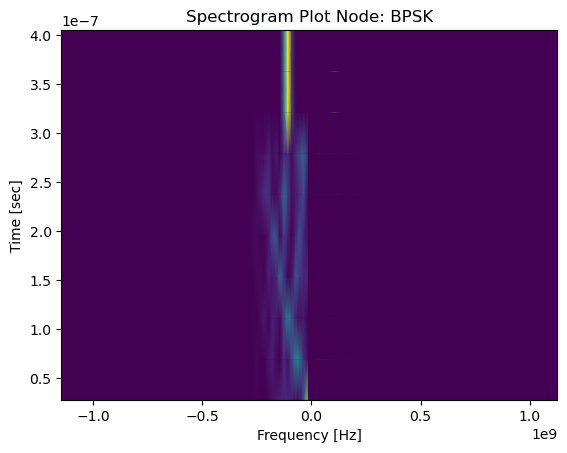

[[3.61553013e-10 7.11124128e-10 2.06193030e-10 ... 1.57835599e-10
  5.36190585e-10 3.74518540e-10]
 [4.56153246e-11 3.52768002e-11 1.08642570e-10 ... 9.33102503e-11
  1.37828452e-10 1.41613870e-10]
 [2.79010390e-11 7.24541205e-11 1.93776847e-11 ... 4.21433332e-11
  1.14970203e-11 1.30757932e-11]
 [1.18474788e-11 2.42879175e-11 2.91959568e-11 ... 5.79473518e-11
  1.18131380e-12 4.68164192e-11]
 [5.97064207e-12 1.45760853e-12 1.98822913e-14 ... 2.38514291e-15
  3.74734812e-15 1.47151668e-12]]
(5, 256)


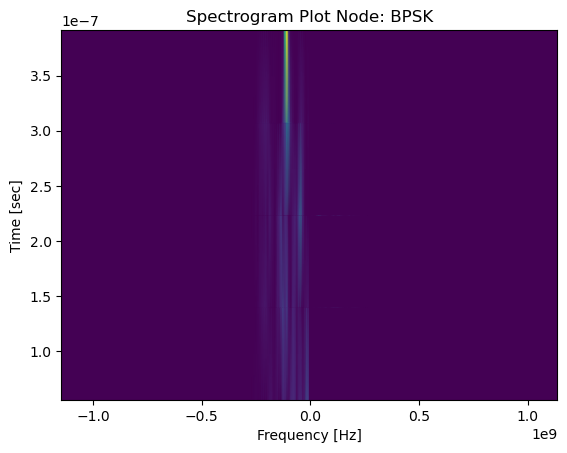

[[2.18542506e-11 1.22883979e-10 2.43546489e-10 ... 2.59748625e-10
  8.94708319e-11 3.48575954e-10]
 [4.35820495e-11 2.61704229e-11 6.75089985e-11 ... 6.66219218e-11
  7.93292548e-11 1.33146515e-10]]
(2, 512)


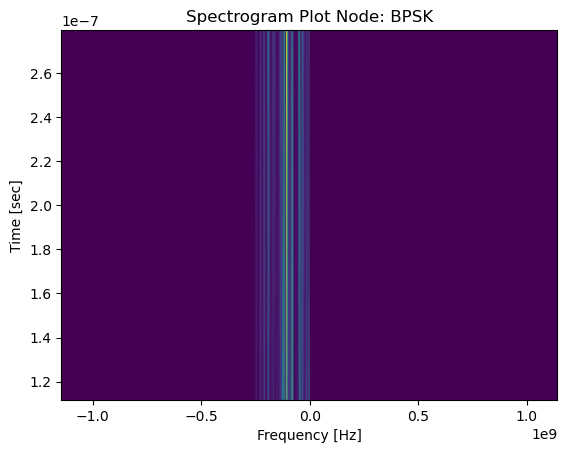

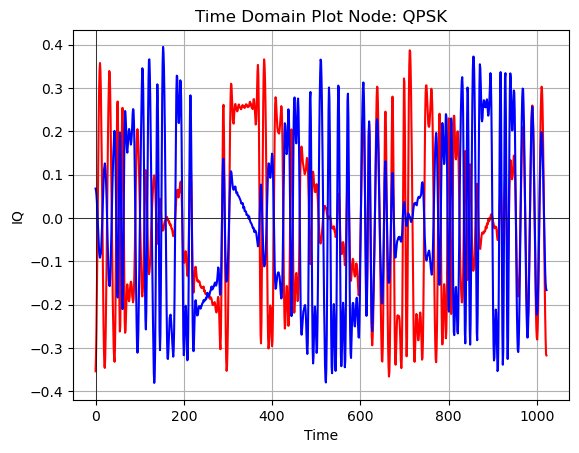

[[2.89944887e-12 2.54609405e-10 2.10859953e-10 ... 1.28217159e-11
  2.35993302e-10 2.22298222e-10]
 [3.15108225e-11 2.25276763e-10 2.41982710e-10 ... 1.98515518e-11
  2.66793149e-10 2.08137737e-10]
 [6.38689056e-13 9.27387990e-11 1.74386062e-10 ... 1.36135482e-10
  1.69031310e-10 9.73487155e-11]
 ...
 [1.56939601e-11 2.64239991e-10 1.46671186e-10 ... 2.89685267e-11
  1.66771113e-10 2.73682543e-10]
 [5.14365270e-11 2.76916745e-10 2.08528702e-10 ... 1.17144763e-11
  2.37134432e-10 2.45801255e-10]
 [1.68560160e-10 3.39874235e-10 2.11207256e-10 ... 1.14143430e-11
  2.40017297e-10 3.05258795e-10]]
(42, 32)


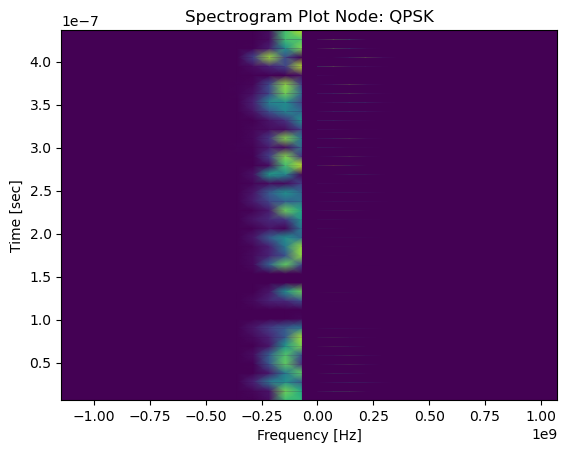

[[2.81370144e-12 4.59335073e-12 1.96307202e-10 ... 5.28190620e-10
  1.29441181e-10 2.15806382e-12]
 [5.13216666e-11 2.05196591e-10 1.82167287e-10 ... 3.16868132e-11
  2.42507559e-10 1.95072966e-10]
 [2.00686252e-11 7.75713962e-11 1.09810642e-10 ... 2.56634854e-10
  9.97417306e-11 5.58707374e-11]
 ...
 [6.22606879e-12 3.57293164e-10 2.51462956e-10 ... 1.19922910e-10
  3.08665333e-10 4.01747366e-10]
 [7.56939321e-12 7.10389368e-11 2.69105269e-10 ... 2.53896197e-10
  2.51740864e-10 5.58086015e-11]
 [7.13566886e-13 1.45826116e-13 1.97849457e-10 ... 6.09812416e-10
  1.14903887e-10 5.45891130e-14]]
(21, 64)


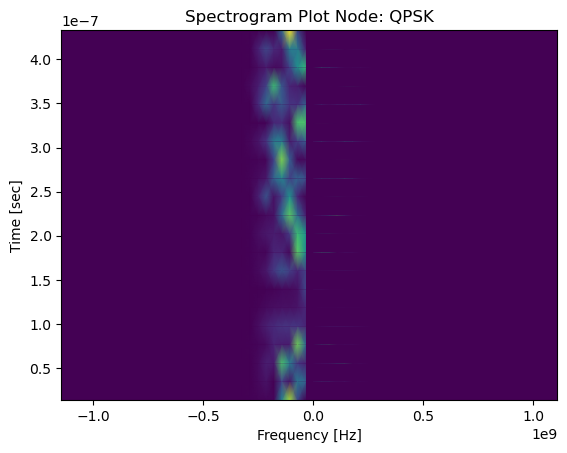

[[1.68529779e-11 5.34822556e-11 1.09120391e-10 ... 1.20029921e-10
  1.21911234e-10 9.15012959e-11]
 [4.92209420e-12 1.51229354e-11 9.02726497e-11 ... 3.11726088e-10
  5.40144645e-11 2.33647903e-11]
 [2.88852584e-10 1.10683824e-10 4.91604272e-12 ... 1.25100200e-11
  6.12637507e-11 3.88299240e-10]
 ...
 [2.03845336e-11 7.15636623e-11 4.97429286e-10 ... 6.86905283e-10
  3.24070497e-10 4.43678814e-11]
 [1.27365807e-10 1.72695594e-10 5.94878383e-11 ... 1.08749216e-10
  7.03843154e-11 1.34704645e-10]
 [3.31927785e-11 9.69805787e-11 2.22217670e-10 ... 1.46405962e-10
  1.90407796e-10 2.41942863e-11]]
(10, 128)


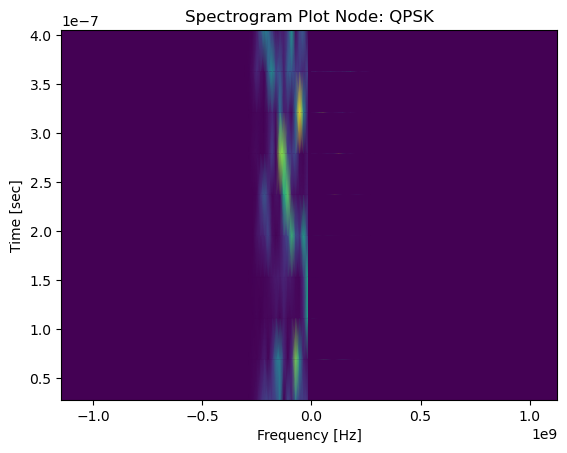

[[8.18476168e-11 2.83706164e-11 2.61258765e-11 ... 1.55742117e-11
  7.93760131e-11 2.75048560e-10]
 [2.23522575e-10 1.10444762e-09 6.23724061e-10 ... 3.34735043e-10
  1.37360986e-09 1.18099839e-09]
 [4.96831536e-11 2.07554691e-11 4.62739844e-11 ... 1.02891335e-10
  3.42427440e-11 2.12502594e-10]
 [2.98160480e-11 1.71463351e-11 3.06267122e-11 ... 6.64482183e-12
  8.34279148e-11 9.44013793e-11]
 [2.63759939e-11 3.80765798e-11 1.78652717e-10 ... 2.20736889e-10
  1.17992948e-10 8.86682168e-11]]
(5, 256)


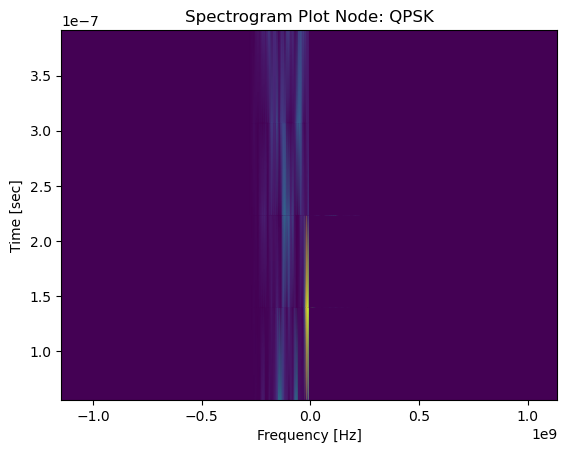

[[9.12903208e-11 9.85663217e-10 1.10882988e-09 ... 1.32970681e-09
  9.44111073e-10 1.19307649e-10]
 [1.49688240e-10 2.78304336e-11 5.15024188e-11 ... 1.56067721e-11
  1.40707482e-10 4.15595255e-10]]
(2, 512)


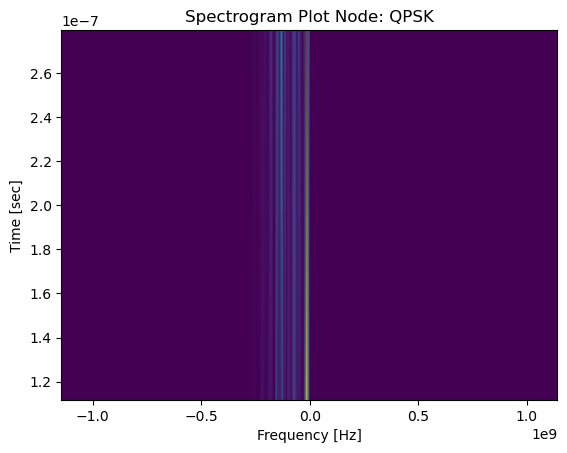

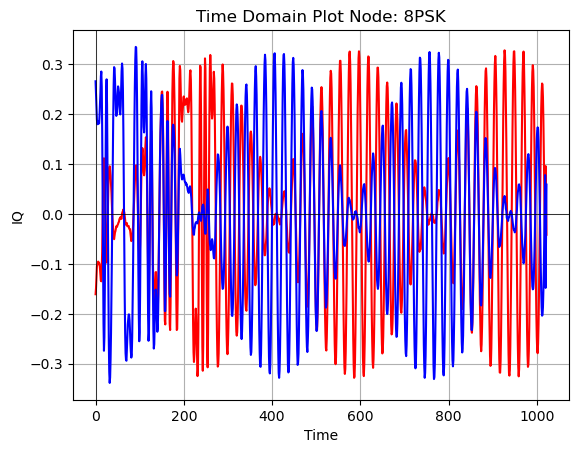

[[1.95941624e-12 8.11881062e-11 1.41674518e-10 ... 1.00468256e-10
  1.44510016e-10 8.40591502e-11]
 [3.21367013e-12 1.87911863e-10 1.00268248e-10 ... 1.84514158e-11
  1.18612518e-10 2.05403313e-10]
 [4.44035664e-13 2.06274595e-10 1.03031542e-10 ... 2.32678073e-11
  1.23269679e-10 2.47699174e-10]
 ...
 [4.98512738e-11 2.31077408e-10 1.69204510e-10 ... 1.02872365e-11
  1.97475229e-10 2.11120188e-10]
 [5.50833431e-12 2.08144260e-10 1.69209289e-10 ... 1.06036380e-11
  2.00985595e-10 1.90431873e-10]
 [1.01633529e-10 2.60742097e-10 1.74716199e-10 ... 1.02663386e-11
  2.06484203e-10 2.41286593e-10]]
(42, 32)


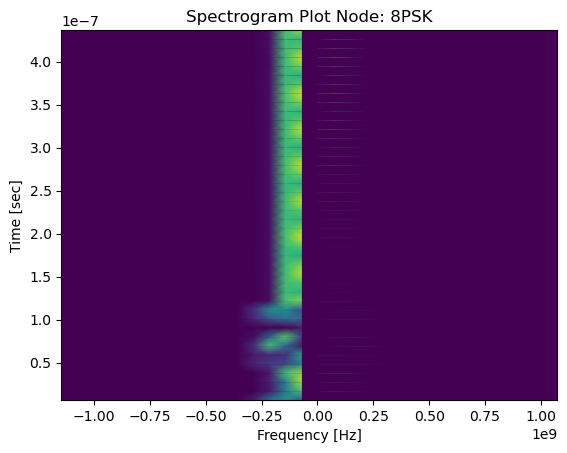

[[1.42365775e-10 2.70791492e-10 1.46140073e-10 ... 1.11895798e-10
  1.64672379e-10 1.97496865e-10]
 [1.93462225e-10 3.04575858e-10 2.79151342e-10 ... 6.86611996e-11
  3.10864718e-10 2.62354894e-10]
 [1.64572685e-11 1.66685816e-10 6.44806670e-11 ... 1.01912325e-10
  1.00651038e-10 1.51997677e-10]
 ...
 [2.96724553e-14 1.08211865e-13 1.59789439e-10 ... 5.09989237e-10
  9.38496345e-11 3.61623497e-14]
 [2.21592987e-12 5.32948914e-14 1.59458117e-10 ... 5.12521783e-10
  9.47583490e-11 1.09802854e-13]
 [4.53030456e-12 6.94249402e-13 1.68681890e-10 ... 5.23989106e-10
  1.00776024e-10 2.15206717e-12]]
(21, 64)


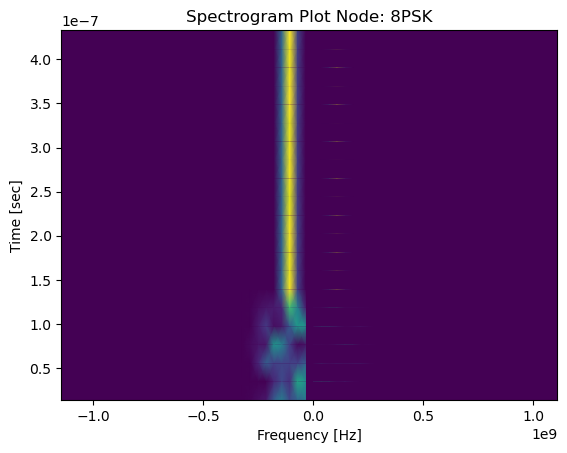

[[2.96030065e-11 1.02425323e-10 4.48781365e-10 ... 5.27081129e-10
  3.09859653e-10 4.82273738e-11]
 [1.65065784e-11 8.62689338e-11 1.42424522e-11 ... 6.47769123e-11
  2.08022471e-11 1.11694194e-10]
 [2.90884660e-11 4.49186654e-11 1.23416909e-10 ... 8.34739979e-11
  1.10260071e-10 4.53508743e-12]
 ...
 [8.16995515e-15 2.72124578e-14 2.77696347e-14 ... 9.58237519e-14
  8.13321963e-15 7.98227177e-15]
 [1.14189230e-14 1.73710901e-15 2.21684728e-14 ... 4.05832611e-14
  8.51169731e-15 5.38999470e-15]
 [4.91067551e-14 2.19677467e-14 1.99993890e-16 ... 6.49891848e-14
  2.96284349e-15 2.06996000e-14]]
(10, 128)


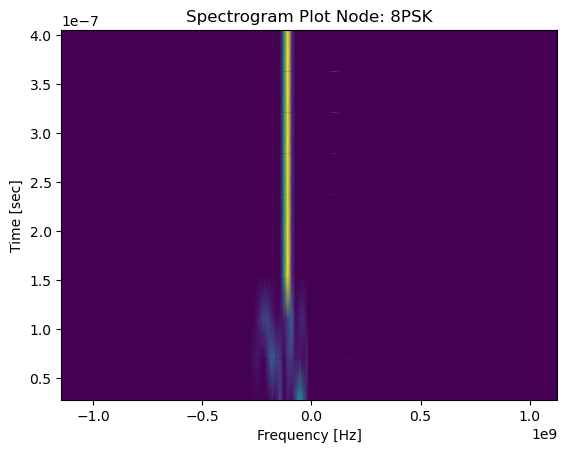

[[2.11413133e-11 7.18849750e-11 4.47664045e-11 ... 7.98822539e-11
  2.51577924e-11 4.58054875e-12]
 [1.54550496e-11 3.15085131e-12 6.13449193e-12 ... 7.33142680e-12
  4.51081855e-12 1.23920369e-11]
 [6.82738548e-14 5.78673621e-15 9.16631071e-15 ... 3.04846047e-16
  7.18106759e-15 5.92805699e-14]
 [1.13513939e-15 1.59051363e-14 3.56123923e-14 ... 2.94142895e-15
  7.51380587e-16 2.80642093e-15]
 [9.64444761e-13 2.34753727e-13 1.48376603e-14 ... 1.40359870e-14
  9.62224063e-15 3.00785307e-13]]
(5, 256)


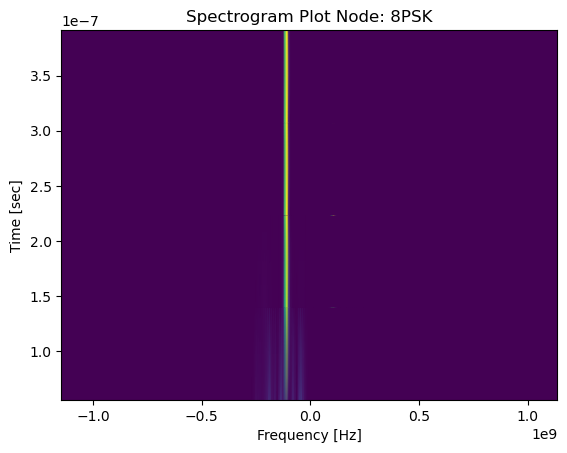

[[3.05059818e-11 1.25457168e-11 2.78233880e-11 ... 3.48330240e-11
  6.45865375e-11 9.14178360e-11]
 [1.23745859e-14 1.00616204e-14 6.85757354e-17 ... 8.25187517e-15
  1.41453785e-14 1.66875504e-15]]
(2, 512)


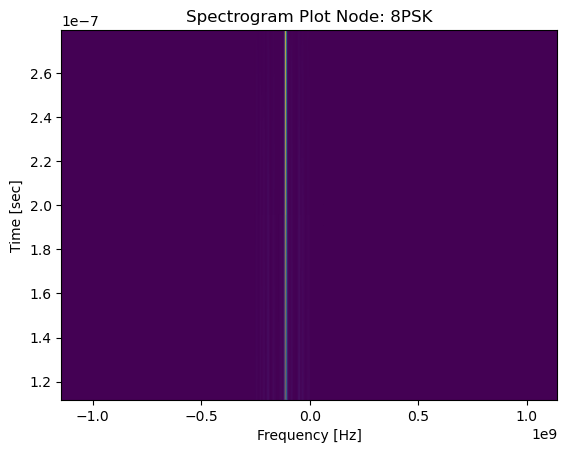

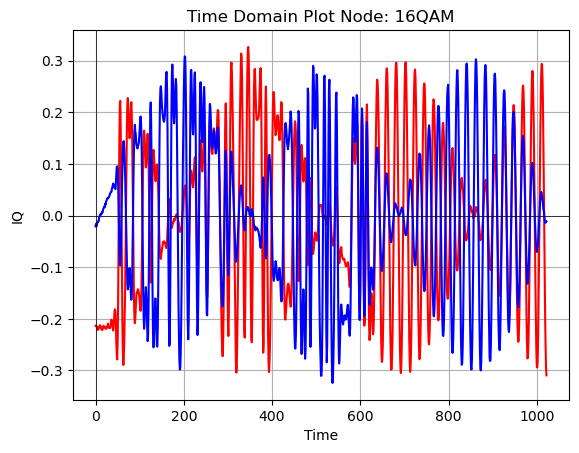

[[9.36364368e-15 4.48851191e-13 1.02002290e-14 ... 7.13572377e-15
  3.95166838e-14 5.83856150e-13]
 [1.08624267e-11 1.44273940e-12 4.61320715e-13 ... 1.37330665e-12
  2.38988638e-13 6.06595854e-12]
 [3.07637057e-11 1.29522833e-10 1.71264328e-10 ... 2.55999133e-11
  1.86152148e-10 1.20131510e-10]
 ...
 [1.25306905e-11 1.79845994e-10 1.40271234e-10 ... 9.08467769e-12
  1.61257738e-10 1.55146024e-10]
 [2.63237867e-11 1.85028950e-10 1.43584667e-10 ... 8.34512423e-12
  1.62385502e-10 1.62763577e-10]
 [1.12012694e-10 2.33502363e-10 1.46572423e-10 ... 8.01923817e-12
  1.68220811e-10 2.09398946e-10]]
(42, 32)


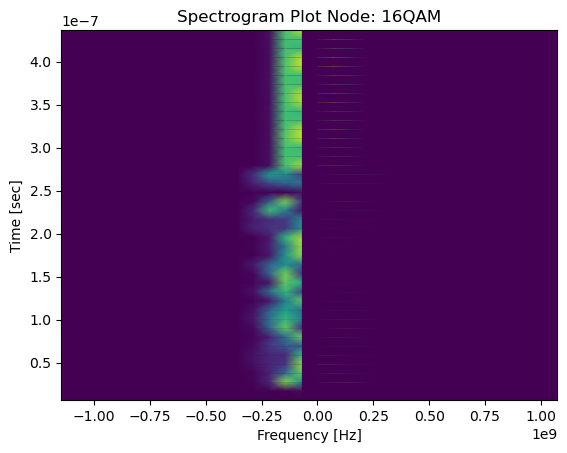

[[1.28924186e-11 3.81792622e-12 2.78729397e-12 ... 2.86560152e-12
  3.02072476e-12 3.35303068e-11]
 [2.03761208e-11 1.97723145e-10 3.18821129e-10 ... 1.37061487e-10
  3.30630375e-10 1.40709282e-10]
 [1.50152568e-10 5.88692869e-11 9.95921694e-11 ... 2.17702391e-10
  5.35598312e-11 9.04555663e-11]
 ...
 [3.29359527e-13 4.66270633e-14 1.36592817e-10 ... 4.30839298e-10
  8.13476188e-11 2.66816380e-14]
 [1.80950394e-12 1.68306884e-13 1.35852977e-10 ... 4.19704663e-10
  7.49235063e-11 9.40546199e-14]
 [2.89949431e-13 1.27951194e-13 1.38834754e-10 ... 4.23727300e-10
  7.62017624e-11 5.72010841e-14]]
(21, 64)


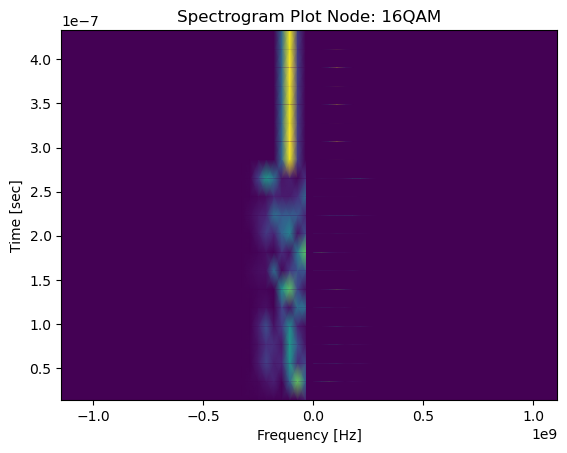

[[1.78892275e-11 1.42807539e-10 1.67805950e-10 ... 9.92465125e-11
  1.69060507e-10 1.50344683e-10]
 [7.41296876e-12 9.76084286e-11 1.21061567e-10 ... 4.72067365e-11
  1.63135845e-10 1.07632812e-10]
 [3.82139817e-11 2.38525703e-11 4.34458954e-11 ... 6.78381611e-11
  4.53374832e-11 8.27177020e-11]
 ...
 [2.51683182e-13 5.87551238e-14 1.48268117e-15 ... 1.51161567e-14
  2.66256895e-14 3.56637342e-14]
 [3.57066221e-13 5.71967863e-14 1.44580286e-14 ... 2.89549342e-14
  1.79198283e-14 8.22025541e-14]
 [4.94196633e-13 1.00798294e-13 1.40911759e-14 ... 9.71471418e-14
  6.18842172e-15 8.68743243e-14]]
(10, 128)


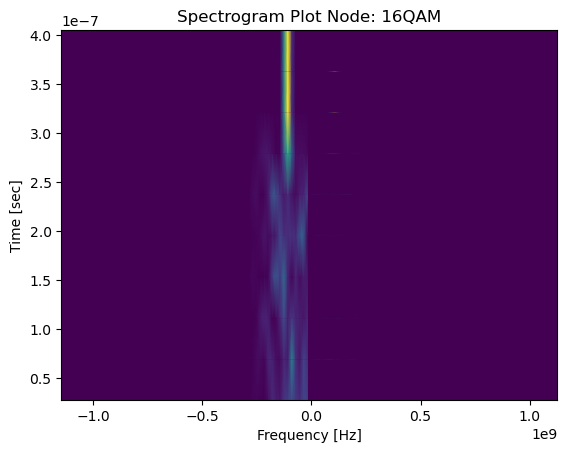

[[6.96423503e-11 2.02720453e-10 8.13245679e-11 ... 7.28147490e-11
  8.89771890e-11 9.79370064e-12]
 [2.30040509e-11 7.64060089e-11 8.49505060e-11 ... 8.39117794e-11
  2.46937627e-11 3.43357395e-11]
 [5.37826146e-12 5.27425167e-11 1.05094441e-10 ... 1.37274754e-10
  5.41449594e-11 3.22925067e-11]
 [8.06905617e-13 1.22157396e-12 1.38914330e-12 ... 1.30623451e-12
  1.04231705e-12 9.65457899e-13]
 [5.67795607e-13 1.52819688e-13 2.64349722e-15 ... 2.64952823e-14
  6.14092859e-15 1.48363568e-13]]
(5, 256)


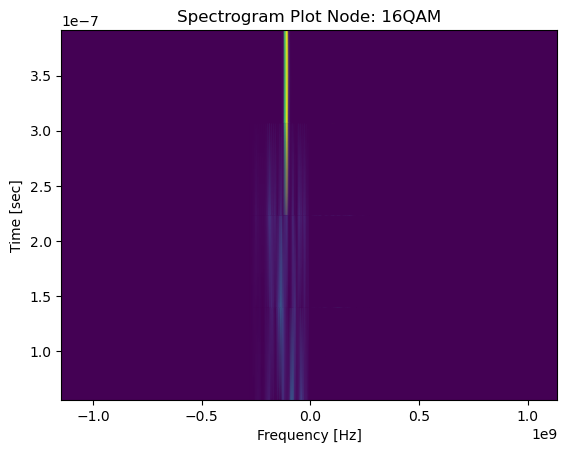

[[1.73642008e-10 2.00874240e-11 6.37198578e-11 ... 4.50639435e-11
  1.59688863e-10 3.75133375e-10]
 [7.75864028e-12 1.32423177e-11 1.75965990e-11 ... 2.22449727e-11
  4.38520212e-11 5.50797861e-11]]
(2, 512)


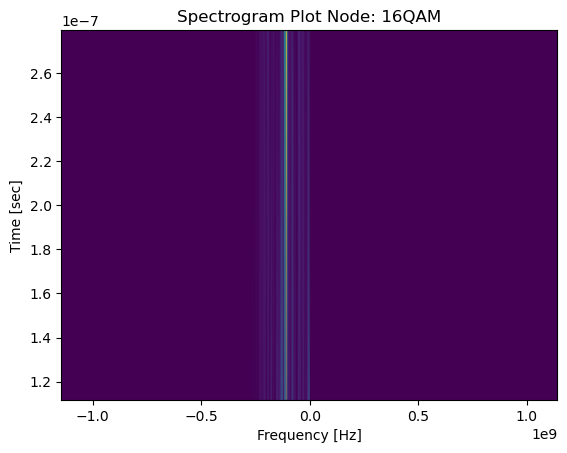

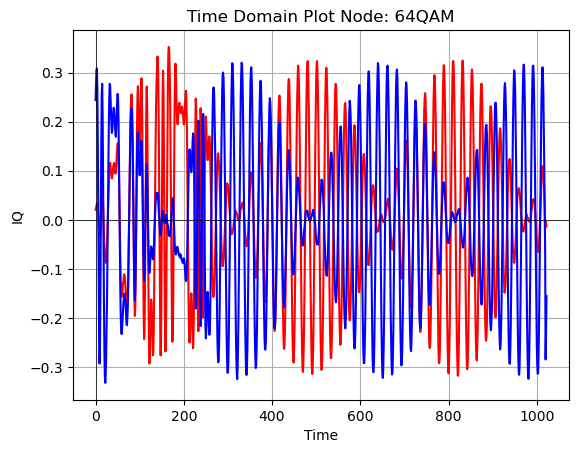

[[2.62902091e-11 2.81517614e-11 1.66135767e-10 ... 1.35722888e-10
  1.61052645e-10 3.15555749e-11]
 [4.47442544e-11 8.91199525e-12 1.23026057e-12 ... 1.52903750e-12
  9.08090033e-13 2.00832663e-11]
 [1.45240760e-10 7.07340990e-11 4.44438559e-12 ... 1.42110850e-11
  3.31153159e-12 9.57247535e-11]
 ...
 [6.90919959e-11 2.31025881e-10 1.58244133e-10 ... 9.67467961e-12
  1.88305571e-10 2.10515181e-10]
 [8.92954473e-13 1.96785134e-10 1.60133049e-10 ... 1.01901704e-11
  1.86044021e-10 1.73425185e-10]
 [7.39456625e-11 2.34618260e-10 1.63058243e-10 ... 1.01109866e-11
  1.91708858e-10 2.10743499e-10]]
(42, 32)


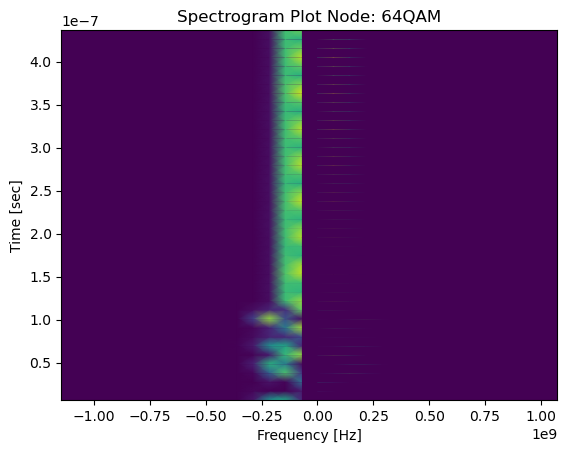

[[2.62870211e-11 2.13000519e-10 1.66802040e-10 ... 9.19769934e-11
  2.00874644e-10 1.77446667e-10]
 [2.52606012e-12 1.21924905e-10 1.06488164e-10 ... 2.04323629e-10
  9.09803938e-11 1.49151535e-10]
 [6.17381870e-11 1.40293256e-10 1.97389213e-10 ... 2.11982637e-10
  1.92201776e-10 1.03274754e-10]
 ...
 [1.85257041e-14 1.85340137e-13 1.55538031e-10 ... 4.82384869e-10
  8.67682563e-11 7.32075175e-14]
 [2.55436920e-12 8.88475303e-14 1.53931861e-10 ... 4.80447957e-10
  8.73177553e-11 1.13345648e-13]
 [7.95467130e-13 2.17481318e-13 1.55300757e-10 ... 4.89118991e-10
  8.75467956e-11 4.88724492e-13]]
(21, 64)


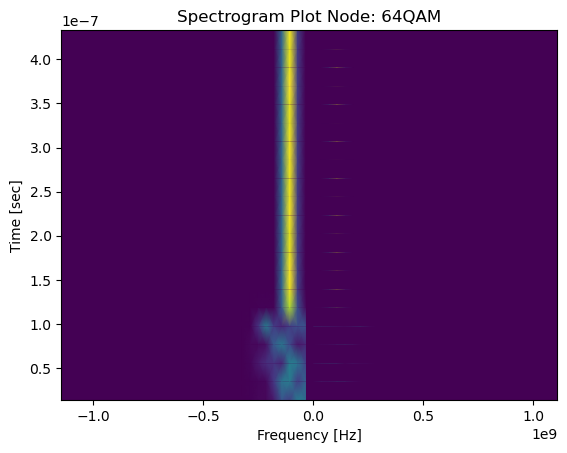

[[1.57092393e-12 9.77838907e-11 4.23702056e-10 ... 4.16471610e-10
  2.99763052e-10 2.27917117e-11]
 [2.43625887e-11 9.83797634e-11 1.21733088e-11 ... 4.89252764e-11
  1.18706246e-11 1.06886263e-10]
 [5.26303723e-12 2.66759132e-11 7.04424301e-11 ... 5.11257293e-11
  6.71739325e-11 1.23309523e-11]
 ...
 [1.14620242e-13 3.80351530e-14 1.06974505e-14 ... 8.54035668e-15
  3.37562548e-14 4.88939099e-14]
 [5.56242834e-14 1.08634664e-14 1.44505082e-14 ... 5.01582463e-14
  1.07834729e-14 1.88572552e-14]
 [1.05091209e-14 2.59399031e-15 3.35706093e-14 ... 4.57829740e-14
  1.02994860e-14 9.70990132e-15]]
(10, 128)


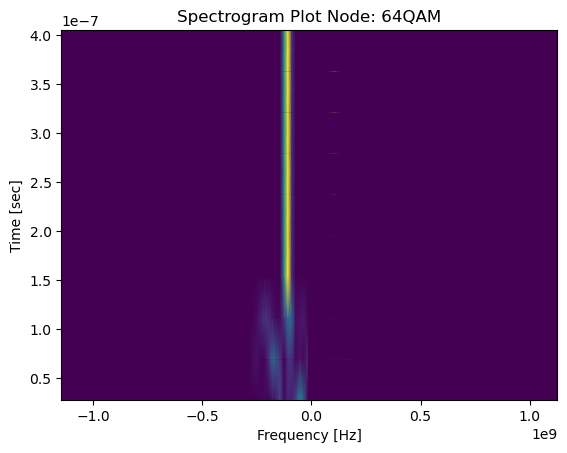

[[2.28488588e-12 5.91188864e-11 7.69453695e-11 ... 1.04223745e-10
  3.95770607e-11 2.52507709e-11]
 [3.58100837e-12 2.41220518e-12 3.57024768e-12 ... 3.81338959e-12
  2.77674544e-12 5.45127424e-12]
 [4.20648549e-13 1.59940542e-13 5.51289663e-15 ... 6.02725901e-15
  2.19019649e-14 1.16194162e-13]
 [1.58661833e-13 4.31875281e-14 3.28977469e-15 ... 8.00784945e-15
  1.46248996e-16 4.30395182e-14]
 [4.44904120e-13 1.17078429e-13 6.00103411e-17 ... 6.68872538e-15
  3.82195321e-15 1.52869989e-13]]
(5, 256)


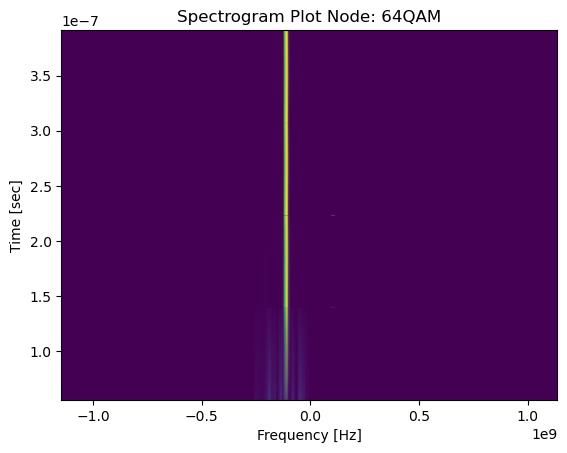

[[1.46877696e-11 1.41055891e-11 2.28082062e-11 ... 3.29515897e-11
  5.77410392e-11 7.15222622e-11]
 [5.06087314e-14 9.45776884e-15 9.32127811e-15 ... 5.06190617e-15
  2.09599429e-14 1.81580763e-14]]
(2, 512)


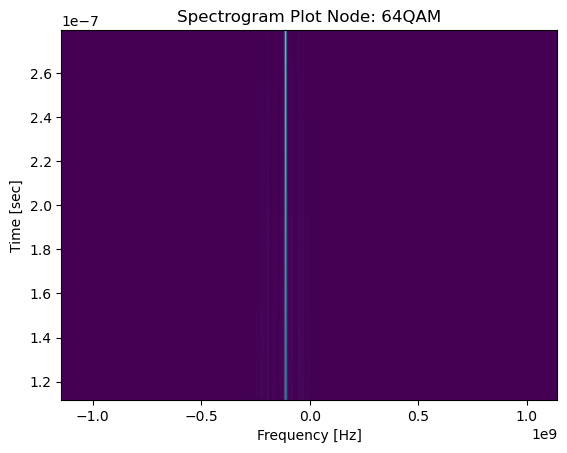

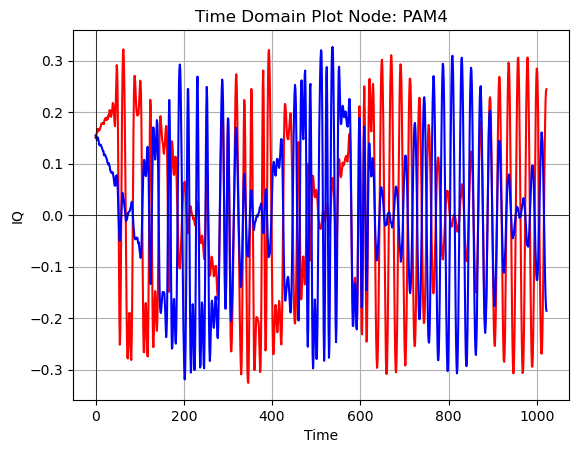

[[2.11210368e-14 5.69704443e-13 2.64855949e-14 ... 1.07919260e-14
  6.03300511e-14 8.74411452e-13]
 [1.54104009e-11 2.20101610e-12 8.55491956e-13 ... 2.12840588e-12
  2.50081416e-13 1.00684880e-11]
 [3.66480980e-11 1.47160904e-10 1.72514923e-10 ... 2.62629901e-11
  2.01209898e-10 1.40890967e-10]
 ...
 [5.61892292e-12 1.82345032e-10 1.43672804e-10 ... 9.01896369e-12
  1.71782260e-10 1.61983842e-10]
 [4.24291522e-11 2.02878925e-10 1.49140364e-10 ... 9.71598437e-12
  1.79489909e-10 1.82029848e-10]
 [1.28187547e-10 2.52329819e-10 1.54980172e-10 ... 8.52689366e-12
  1.83185231e-10 2.32340615e-10]]
(42, 32)


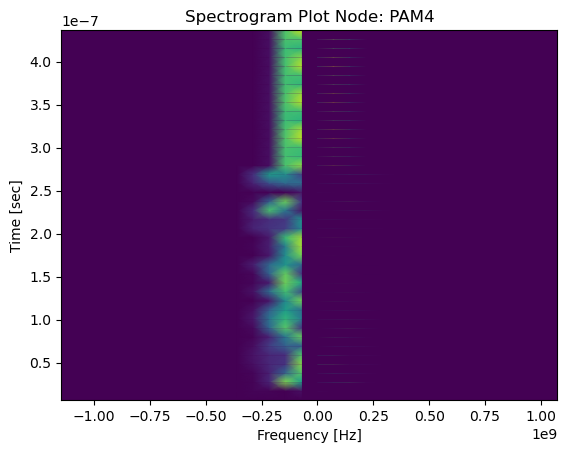

[[1.18917619e-11 2.42490713e-12 3.58374020e-12 ... 3.62758663e-12
  4.63772376e-12 4.02649843e-11]
 [1.55954475e-11 2.15736181e-10 3.37904522e-10 ... 1.46029057e-10
  3.56987093e-10 1.42827400e-10]
 [1.59699483e-10 6.32263101e-11 1.13366894e-10 ... 2.40499257e-10
  6.14528304e-11 1.04210023e-10]
 ...
 [6.09305664e-13 6.09737679e-14 1.47184661e-10 ... 4.49601211e-10
  8.04978411e-11 3.85826057e-14]
 [2.09617368e-12 1.66291259e-13 1.46059835e-10 ... 4.47372808e-10
  7.86962805e-11 1.19016179e-13]
 [7.70136464e-13 1.16120437e-13 1.49058230e-10 ... 4.60453833e-10
  8.19586247e-11 1.02240825e-13]]
(21, 64)


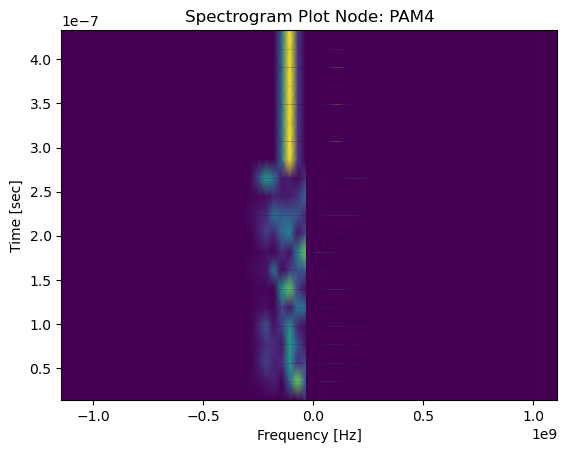

[[2.02560942e-11 1.47174798e-10 1.76713187e-10 ... 1.14445962e-10
  1.73075751e-10 1.51938164e-10]
 [1.02147795e-11 1.03449175e-10 1.25362113e-10 ... 5.51824423e-11
  1.75558979e-10 1.14324174e-10]
 [4.30947434e-11 2.65054764e-11 5.10299315e-11 ... 7.60037421e-11
  5.33990885e-11 9.80819373e-11]
 ...
 [6.02996185e-13 1.50473536e-13 1.46995552e-14 ... 2.64862127e-14
  3.31704834e-14 1.15754219e-13]
 [8.73175003e-13 1.95405736e-13 1.50546933e-14 ... 6.15930602e-14
  2.62679391e-14 2.50892209e-13]
 [1.12428506e-12 2.36648183e-13 4.23685456e-15 ... 4.23581628e-14
  1.60655640e-14 2.74028978e-13]]
(10, 128)


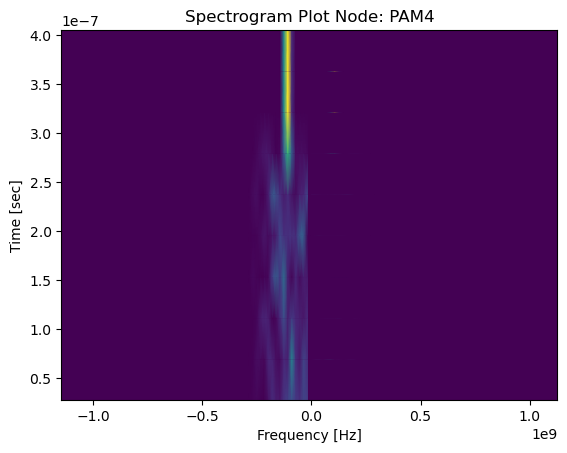

[[5.97024698e-11 1.99232428e-10 8.64817666e-11 ... 8.33461896e-11
  8.80223779e-11 2.55880076e-12]
 [2.92440578e-11 9.36276972e-11 9.10356989e-11 ... 9.18358767e-11
  1.95356297e-11 5.39970588e-11]
 [7.98658085e-12 5.77274126e-11 1.20865416e-10 ... 1.39390135e-10
  5.73632303e-11 3.78959604e-11]
 [8.23195043e-13 1.93637906e-12 1.14621848e-12 ... 1.08244014e-12
  9.63547900e-13 1.02860084e-12]
 [1.10009579e-12 2.94718083e-13 1.03487934e-14 ... 6.45704792e-16
  1.81930182e-14 1.81452024e-13]]
(5, 256)


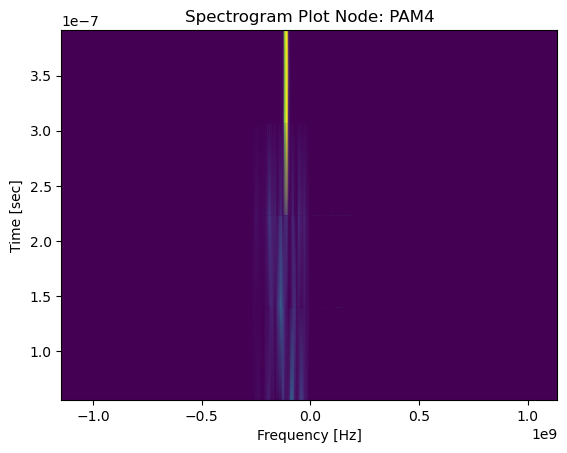

[[2.14907335e-10 2.99504606e-11 6.82026721e-11 ... 4.69991339e-11
  2.06959351e-10 4.80366704e-10]
 [8.75938738e-12 1.36849574e-11 1.61447156e-11 ... 2.48406020e-11
  4.87494964e-11 6.02577741e-11]]
(2, 512)


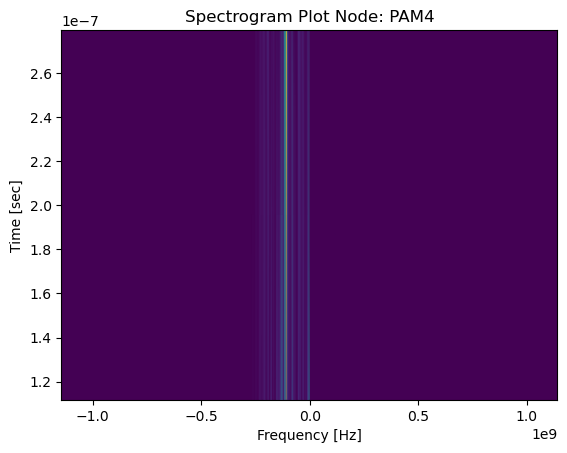

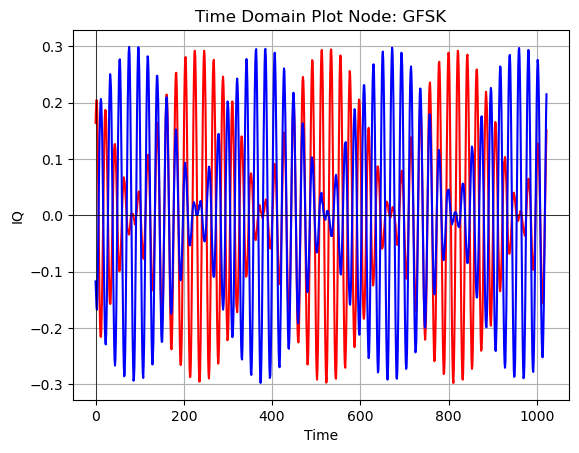

[[2.12627689e-11 1.77477633e-10 1.35406627e-10 ... 8.00784559e-12
  1.63553878e-10 1.59994400e-10]
 [1.32240631e-11 1.69774905e-10 1.32170209e-10 ... 8.88941111e-12
  1.60414782e-10 1.50662662e-10]
 [9.64822526e-11 2.15130418e-10 1.35143218e-10 ... 8.60514563e-12
  1.64583174e-10 1.95156287e-10]
 ...
 [6.10324674e-11 1.99299724e-10 1.34099711e-10 ... 8.82060738e-12
  1.62632583e-10 1.80238895e-10]
 [7.96569760e-13 1.64925360e-10 1.32803340e-10 ... 8.99357546e-12
  1.61905656e-10 1.47977476e-10]
 [6.07229386e-11 2.00088980e-10 1.38292754e-10 ... 8.52395889e-12
  1.66046630e-10 1.80355809e-10]]
(42, 32)


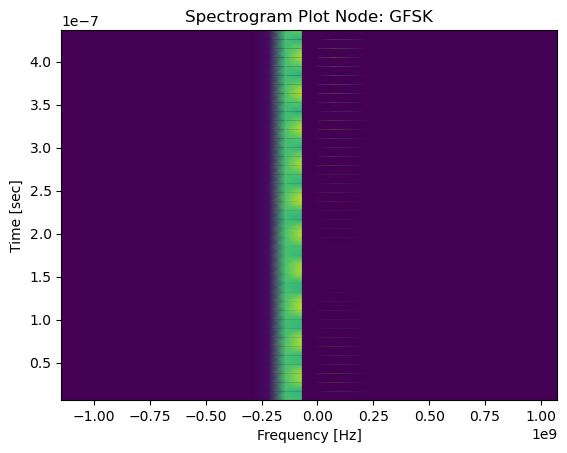

[[5.49026631e-13 1.19727545e-13 1.35917533e-10 ... 4.11873614e-10
  6.98305483e-11 1.95599337e-13]
 [2.09547772e-12 9.33291977e-14 1.37584027e-10 ... 4.14263586e-10
  7.16565710e-11 5.62478152e-14]
 [4.97928070e-13 1.05979772e-13 1.36452805e-10 ... 4.22382369e-10
  7.55236655e-11 1.38163557e-13]
 ...
 [3.35384296e-14 1.58203258e-13 1.35194325e-10 ... 4.14379189e-10
  7.22390523e-11 6.53508832e-14]
 [2.73075329e-12 1.03551775e-13 1.33227623e-10 ... 4.08543443e-10
  7.15323687e-11 1.11977362e-13]
 [9.81118129e-15 1.75863622e-13 1.37832889e-10 ... 4.21707691e-10
  7.49695142e-11 6.08548884e-14]]
(21, 64)


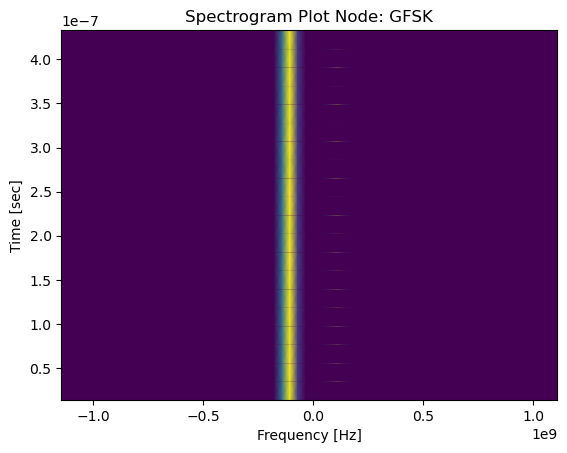

[[7.85634374e-13 9.10878272e-14 2.41628341e-14 ... 4.82195463e-14
  2.27805976e-14 2.84035478e-13]
 [6.95618335e-13 1.67049530e-13 1.59217241e-14 ... 9.11834441e-14
  4.78599740e-16 1.35663421e-13]
 [6.46043834e-13 1.22350816e-13 3.70069933e-14 ... 1.25032788e-14
  2.37986217e-14 1.98064087e-13]
 ...
 [1.55222089e-13 7.39492783e-14 2.72232850e-14 ... 6.77003065e-14
  4.86515988e-14 5.92562843e-14]
 [1.18562875e-13 2.18555531e-14 3.61290183e-14 ... 6.23892154e-14
  1.50405072e-14 9.29988592e-14]
 [2.23475486e-14 1.69235919e-15 2.11364841e-14 ... 4.41806463e-14
  9.97049749e-15 5.83448831e-15]]
(10, 128)


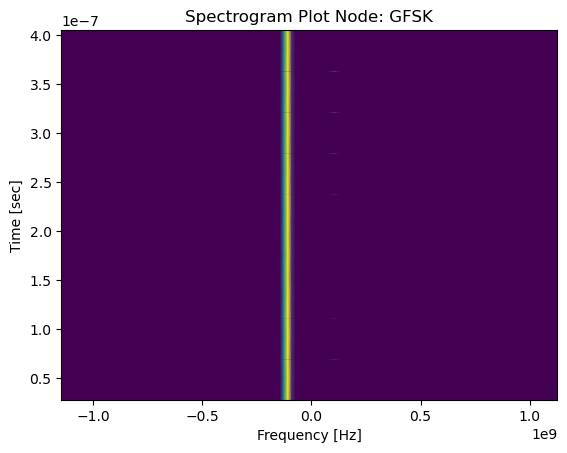

[[7.76767221e-13 2.09714168e-13 5.74743294e-15 ... 1.17122550e-14
  1.26886927e-15 2.14817047e-13]
 [7.65411165e-13 1.56371212e-13 2.29713771e-14 ... 6.35101909e-15
  1.53216828e-15 2.67031637e-13]
 [4.94847788e-13 1.54401051e-13 3.27504130e-15 ... 9.34985000e-15
  1.09565247e-15 1.45390273e-13]
 [1.84711795e-13 2.12505740e-14 1.34590006e-15 ... 2.04175907e-14
  9.41079191e-15 8.86055797e-14]
 [6.54054297e-14 2.65548159e-14 5.46113442e-15 ... 3.03115517e-14
  1.28017602e-14 7.71805290e-15]]
(5, 256)


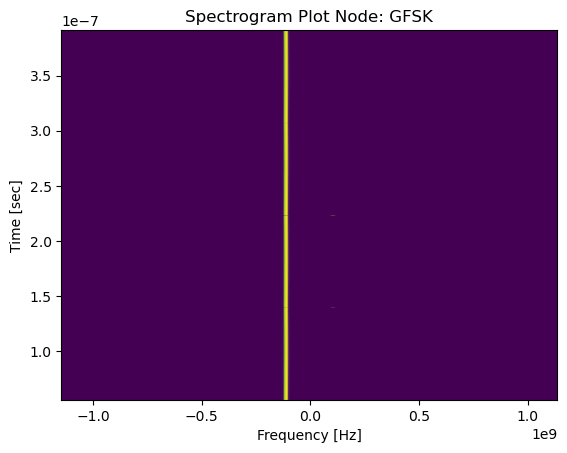

[[1.19558899e-13 2.85303517e-14 9.10962757e-15 ... 6.71389162e-15
  1.72241337e-14 8.68011892e-14]
 [1.05106112e-13 4.68142404e-14 1.72696229e-16 ... 7.08907052e-15
  3.77130107e-14 9.77215270e-14]]
(2, 512)


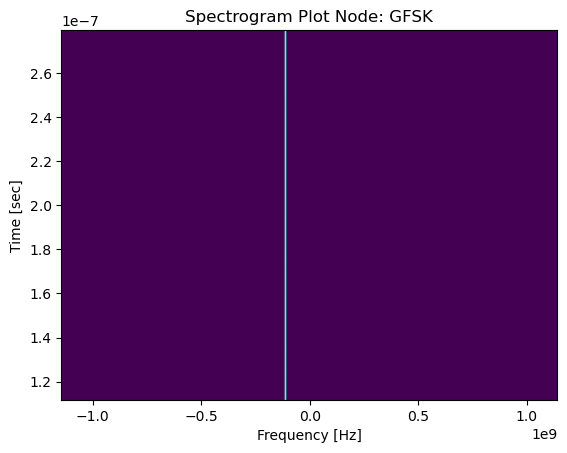

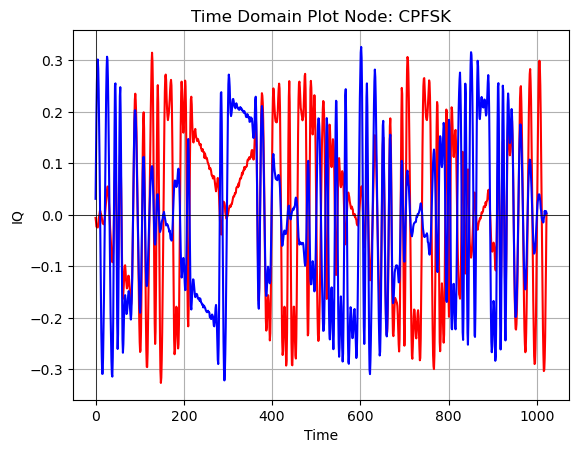

[[1.24586704e-10 2.41628053e-10 1.43309724e-10 ... 8.53277509e-12
  1.76749441e-10 2.23466311e-10]
 [5.31984159e-11 8.41830375e-11 1.73883447e-10 ... 7.70445043e-11
  1.86540726e-10 7.31755018e-11]
 [9.52154855e-13 4.95747275e-11 4.15289905e-11 ... 3.93466814e-11
  4.78159753e-11 6.48977364e-11]
 ...
 [1.48555671e-10 2.50688746e-10 1.46409507e-10 ... 1.05733824e-11
  1.74375716e-10 2.30734460e-10]
 [9.49406744e-11 2.24139704e-10 1.39248077e-10 ... 9.44256387e-12
  1.72903691e-10 2.03185333e-10]
 [9.37621010e-12 1.75891678e-10 1.35834322e-10 ... 9.20314905e-12
  1.66481359e-10 1.57393111e-10]]
(42, 32)


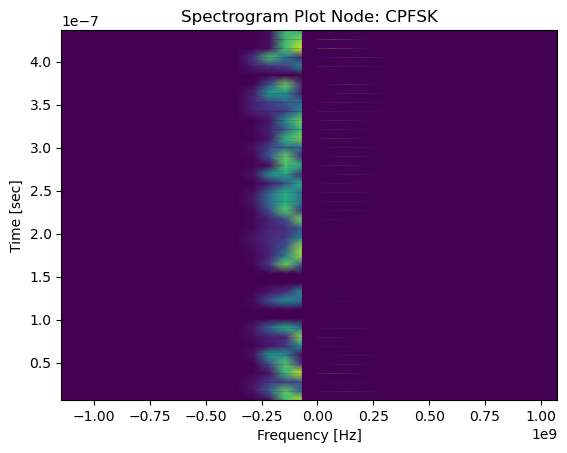

[[4.79072666e-12 5.90202903e-12 1.27504747e-10 ... 2.90820180e-10
  9.31006679e-11 7.80475496e-12]
 [9.81429135e-12 1.30883208e-10 1.77459784e-10 ... 9.53586792e-11
  2.10263405e-10 1.28184744e-10]
 [1.91826315e-11 5.75256457e-11 9.20178085e-11 ... 1.13984090e-10
  8.99045697e-11 4.06826661e-11]
 ...
 [5.25036124e-11 2.57094848e-10 2.17809335e-10 ... 1.18586203e-10
  2.56890148e-10 2.71005409e-10]
 [1.16318895e-11 4.86431076e-11 2.30301949e-10 ... 2.63662161e-10
  1.94864001e-10 4.21153734e-11]
 [2.35992699e-12 1.32453322e-13 1.39958571e-10 ... 4.29930766e-10
  7.31864398e-11 1.35877974e-13]]
(21, 64)


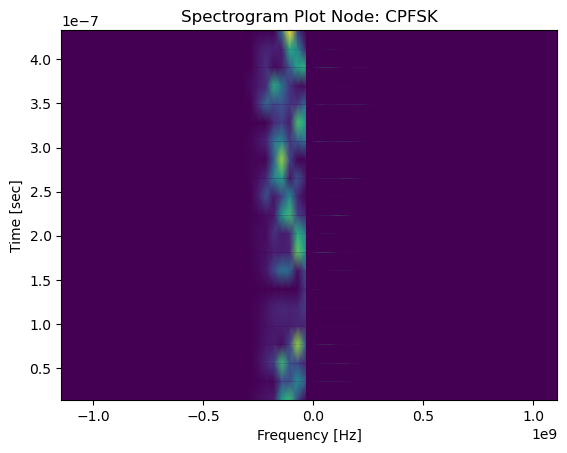

[[4.32020341e-11 5.07988238e-11 9.23375357e-11 ... 1.05608641e-10
  9.58721912e-11 8.18249474e-11]
 [1.66104090e-11 1.04149130e-11 8.22944821e-11 ... 2.31928772e-10
  4.02536487e-11 1.71982132e-11]
 [1.92980964e-10 6.52323198e-11 2.74644878e-12 ... 6.63892189e-12
  6.06909795e-11 3.54610953e-10]
 ...
 [1.86921959e-11 6.45518460e-11 3.80800066e-10 ... 4.66151269e-10
  2.42352010e-10 4.46286471e-11]
 [4.25432241e-11 8.19035820e-11 2.15185970e-11 ... 6.07881997e-11
  3.11241212e-11 9.77103144e-11]
 [4.06479945e-11 5.81565851e-11 1.22445592e-10 ... 8.69148437e-11
  1.02047144e-10 6.87036365e-12]]
(10, 128)


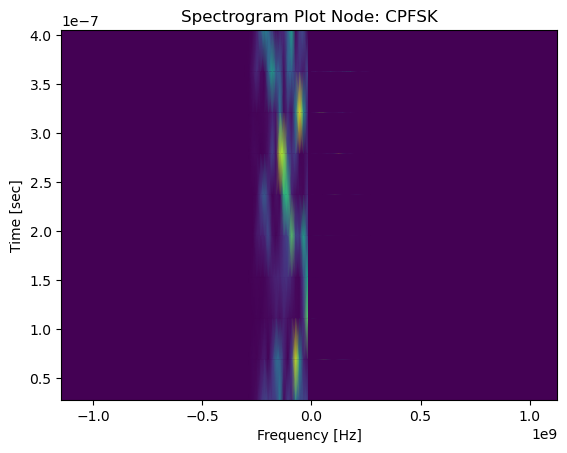

[[4.42794839e-11 4.16221099e-12 1.50021818e-11 ... 1.45617216e-11
  5.42147252e-11 1.97175697e-10]
 [1.91777260e-10 7.00346188e-10 3.71222550e-10 ... 3.01242493e-10
  9.58845951e-10 7.07334646e-10]
 [4.40011769e-11 5.04499635e-12 4.60272543e-11 ... 6.08839684e-11
  3.69049598e-11 1.75031496e-10]
 [2.10113685e-11 1.42692005e-11 1.48363527e-11 ... 1.12155918e-11
  6.34300985e-11 8.07059636e-11]
 [2.10371076e-11 2.72264019e-11 1.16015223e-10 ... 1.29595207e-10
  6.95733832e-11 6.88450309e-11]]
(5, 256)


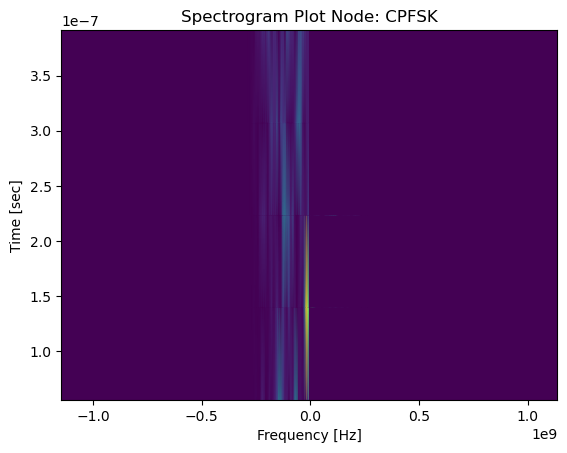

[[7.74507883e-11 6.82484707e-10 7.35962243e-10 ... 9.86494610e-10
  5.16983423e-10 4.02406846e-11]
 [1.03463289e-10 6.19260004e-12 4.28885472e-11 ... 2.73238335e-12
  1.50757242e-10 3.80058955e-10]]
(2, 512)


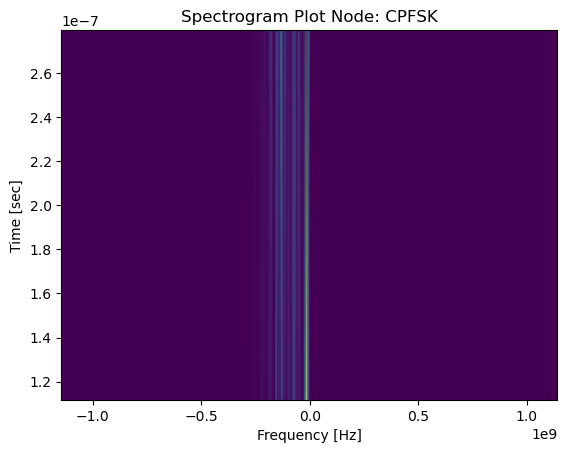

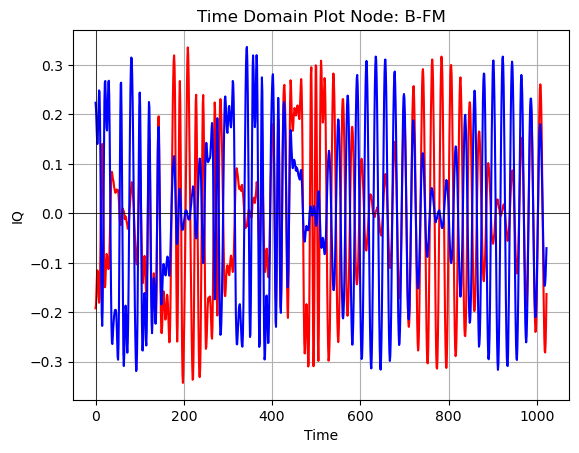

[[5.99711613e-11 1.37606423e-10 1.65032721e-10 ... 9.68195870e-11
  1.71261477e-10 1.05993453e-10]
 [7.16902273e-11 8.94440141e-11 2.95558476e-11 ... 1.70634121e-11
  3.41430016e-11 1.24853808e-10]
 [3.09708958e-12 8.98041119e-11 6.98377332e-11 ... 5.18096916e-11
  8.56683282e-11 8.65158671e-11]
 ...
 [5.61330978e-11 2.23279120e-10 1.59547771e-10 ... 1.01883075e-11
  1.89334041e-10 1.97006469e-10]
 [1.35221484e-10 2.64033064e-10 1.60338696e-10 ... 9.63929125e-12
  1.93799395e-10 2.42420638e-10]
 [7.77705077e-11 2.35172523e-10 1.55630017e-10 ... 9.57693370e-12
  1.85972454e-10 2.08489169e-10]]
(42, 32)


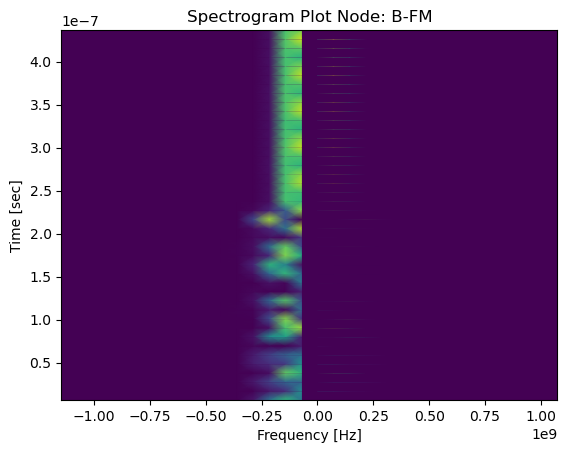

[[8.55138264e-12 1.90898659e-10 2.66366722e-10 ... 1.22240613e-10
  2.98994741e-10 2.23446612e-10]
 [2.10767377e-11 7.43997671e-11 2.40008407e-10 ... 3.60135935e-10
  1.89188217e-10 3.98428170e-11]
 [1.82772394e-12 8.59234258e-13 7.83482917e-11 ... 2.39296317e-10
  4.42803345e-11 2.54912590e-12]
 ...
 [3.12606830e-12 6.34183731e-14 1.56564902e-10 ... 4.73152015e-10
  8.20678070e-11 1.41286775e-13]
 [9.06791492e-14 2.33982153e-13 1.59516174e-10 ... 4.78465387e-10
  8.30017301e-11 1.10250986e-13]
 [3.25914320e-12 1.05162551e-13 1.56064512e-10 ... 4.74908423e-10
  8.21102891e-11 1.54917599e-13]]
(21, 64)


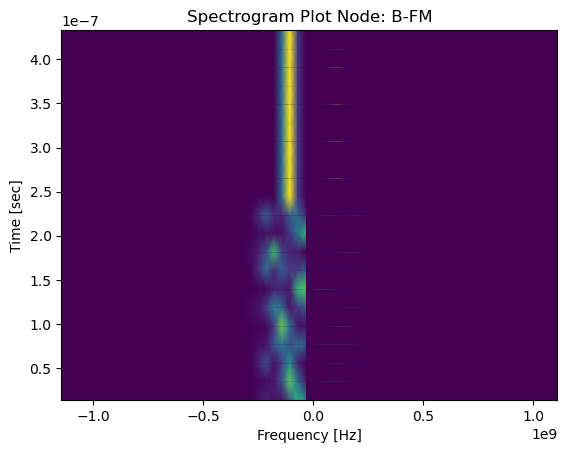

[[7.14409547e-11 7.62627257e-11 9.94395714e-11 ... 2.98873378e-11
  1.07823607e-10 7.33435517e-11]
 [1.10110106e-11 5.28466437e-11 9.15343640e-11 ... 1.20275056e-10
  1.01363871e-10 9.96521392e-11]
 [4.83295097e-12 2.71689014e-11 9.42633705e-11 ... 1.15303193e-10
  9.68328953e-11 2.81231385e-11]
 ...
 [4.29900902e-12 6.45682810e-13 6.39925973e-16 ... 9.22437116e-14
  1.16516780e-14 9.78720660e-13]
 [4.50603268e-12 9.82571596e-13 3.02796021e-14 ... 5.62562215e-14
  1.18751484e-14 8.75942757e-13]
 [4.67940395e-12 1.09478717e-12 3.15968545e-14 ... 6.38512187e-14
  9.73922386e-15 9.21726827e-13]]
(10, 128)


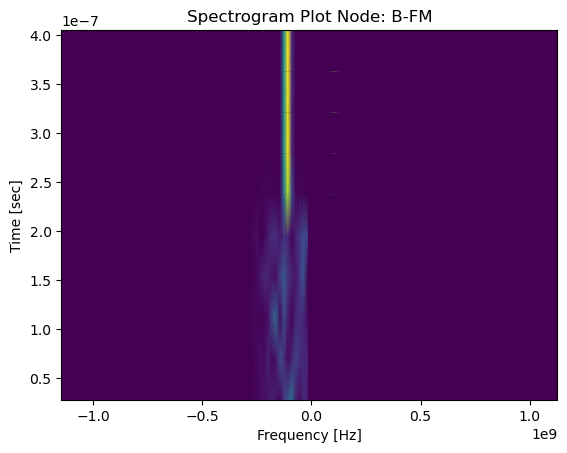

[[8.93027580e-11 1.72352837e-11 6.35556849e-11 ... 6.58570271e-11
  9.21682375e-11 1.83669383e-10]
 [1.93642441e-12 2.77487676e-11 2.19414853e-11 ... 2.42817124e-11
  1.59626282e-11 4.02933360e-11]
 [1.27187323e-12 1.73904302e-11 4.03379516e-11 ... 4.89257020e-11
  5.66821513e-12 4.27871264e-11]
 [4.82572497e-12 1.07014164e-12 2.42859880e-14 ... 1.01247287e-14
  1.27196691e-14 1.02055330e-12]
 [5.02570907e-12 1.16985083e-12 5.22053734e-15 ... 2.59007697e-15
  1.93880489e-15 1.19311418e-12]]
(5, 256)


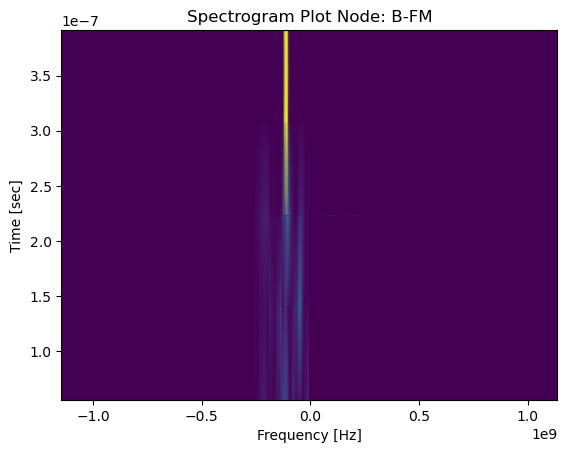

[[3.34229064e-11 2.08999692e-12 4.81270788e-11 ... 3.37625535e-12
  1.05189219e-10 3.33161364e-10]
 [6.32845969e-12 8.29001376e-12 2.37391110e-13 ... 1.55571117e-12
  3.25524953e-12 1.16420081e-11]]
(2, 512)


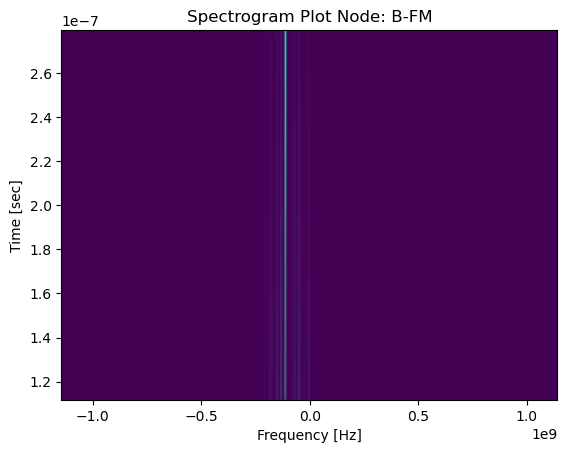

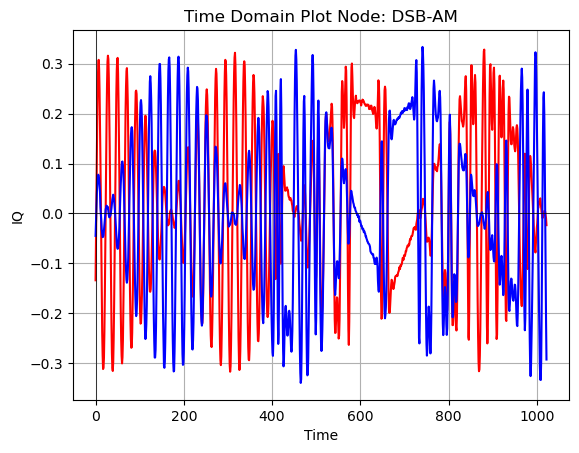

[[1.02285917e-10 2.42610499e-10 1.57053191e-10 ... 9.45137104e-12
  1.90202429e-10 2.22401802e-10]
 [1.26787145e-10 2.61850084e-10 1.57165813e-10 ... 9.46296390e-12
  1.92841550e-10 2.38310449e-10]
 [3.13327111e-11 2.06383058e-10 1.52656551e-10 ... 1.03886901e-11
  1.89107783e-10 1.89173982e-10]
 ...
 [4.53573284e-11 4.37748619e-11 1.25596087e-11 ... 1.21376230e-11
  1.56033953e-11 7.30529261e-11]
 [1.07872039e-12 1.06380585e-14 1.33147691e-10 ... 1.54229337e-10
  1.20634126e-10 4.52297082e-12]
 [6.97035301e-11 2.27499293e-10 1.48292310e-10 ... 8.80340179e-12
  1.85229703e-10 2.02837249e-10]]
(42, 32)


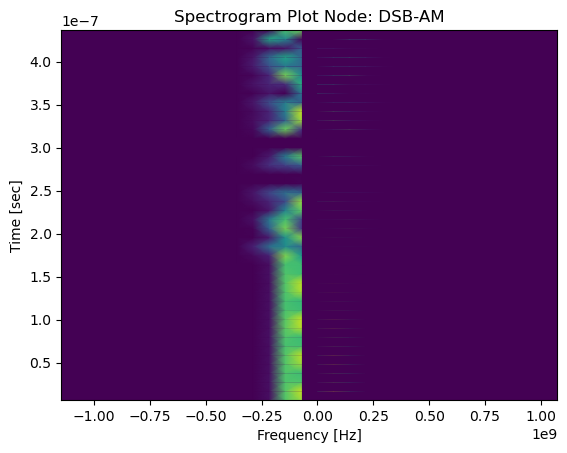

[[2.16789306e-12 3.69333946e-14 1.57461224e-10 ... 4.81614868e-10
  8.39345531e-11 8.07573188e-14]
 [7.98550651e-13 4.11447242e-13 1.60706627e-10 ... 4.88212239e-10
  8.51268978e-11 8.08759698e-14]
 [2.60158386e-12 6.18061953e-14 1.56156635e-10 ... 4.76317766e-10
  8.29941378e-11 1.75471618e-13]
 ...
 [1.68505675e-11 7.70577665e-12 5.42336031e-11 ... 2.25830424e-10
  3.79463603e-11 2.52086331e-11]
 [2.09652627e-11 6.73830481e-11 1.02249071e-10 ... 4.37637898e-12
  1.41107159e-10 8.17234693e-11]
 [7.33465736e-12 1.56882733e-11 1.40372180e-10 ... 3.00844191e-10
  1.01083991e-10 1.30295339e-12]]
(21, 64)


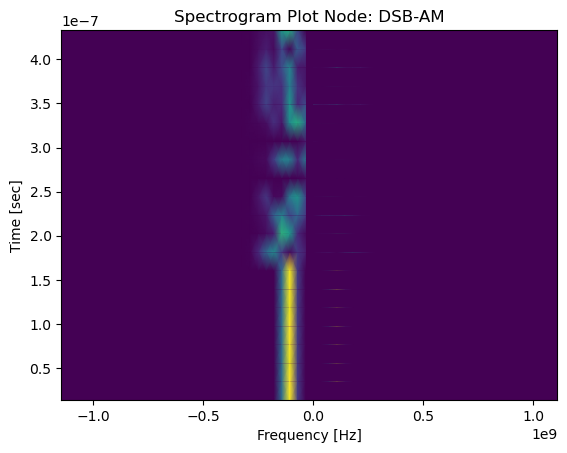

[[3.20576932e-12 6.17523535e-13 9.19448322e-16 ... 4.31164359e-14
  7.93459161e-15 5.48361497e-13]
 [3.80520885e-12 7.84071773e-13 1.74598125e-14 ... 5.14472213e-14
  6.29274724e-15 7.43903629e-13]
 [4.03105447e-12 9.39307213e-13 2.33802125e-14 ... 4.29401684e-14
  1.43414456e-14 7.20582269e-13]
 ...
 [2.13136531e-11 1.46988447e-10 1.37212123e-10 ... 6.24775851e-11
  1.99210256e-10 2.36782288e-10]
 [4.98282026e-12 1.56917214e-10 1.46224478e-10 ... 6.94611324e-11
  2.21408992e-10 1.17494866e-10]
 [5.61622878e-11 1.56698459e-11 3.33281548e-11 ... 5.08680319e-11
  2.79629145e-11 9.63145387e-11]]
(10, 128)


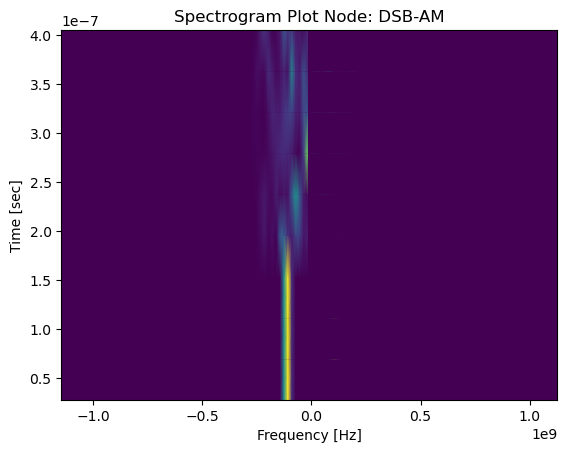

[[3.77719230e-12 9.40725645e-13 2.88019712e-15 ... 3.57117918e-16
  3.66184604e-15 8.71789141e-13]
 [4.17127234e-11 1.47904079e-11 2.25686135e-13 ... 1.67999532e-13
  3.04600114e-13 1.62601871e-11]
 [7.69806375e-11 8.98537976e-12 2.40161535e-11 ... 2.45533206e-11
  2.59639670e-11 3.21699518e-10]
 [3.70412472e-10 6.82704121e-10 3.31512627e-10 ... 3.02841811e-10
  7.74997666e-10 5.49380386e-10]
 [6.27267138e-11 1.04871222e-11 5.50644419e-11 ... 6.46149488e-11
  5.18536699e-11 1.85733700e-10]]
(5, 256)


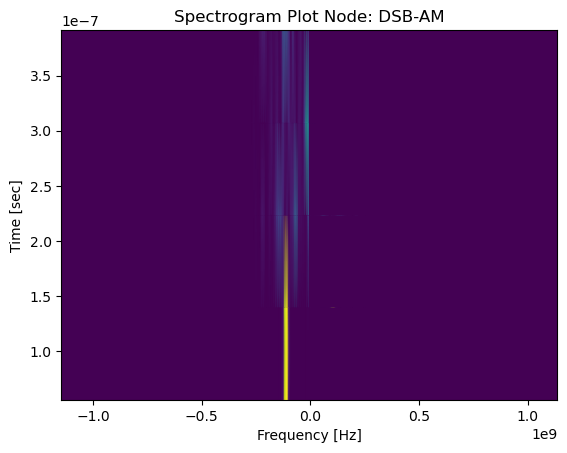

[[5.89235111e-12 1.27419164e-11 2.55770998e-12 ... 2.87486090e-12
  2.94766201e-12 1.08025160e-11]
 [7.61374396e-11 7.12715401e-10 9.15445196e-10 ... 1.09195085e-09
  5.47920769e-10 4.96949625e-11]]
(2, 512)


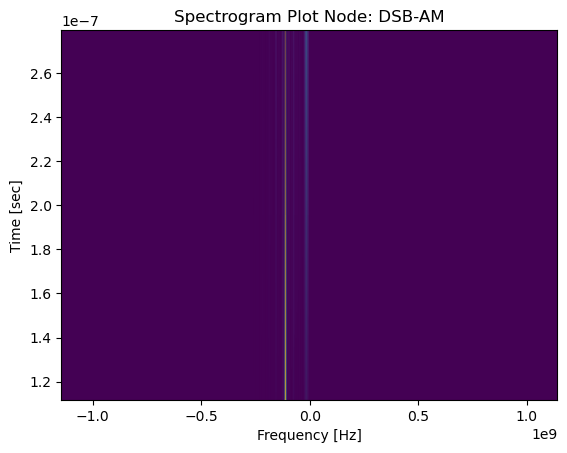

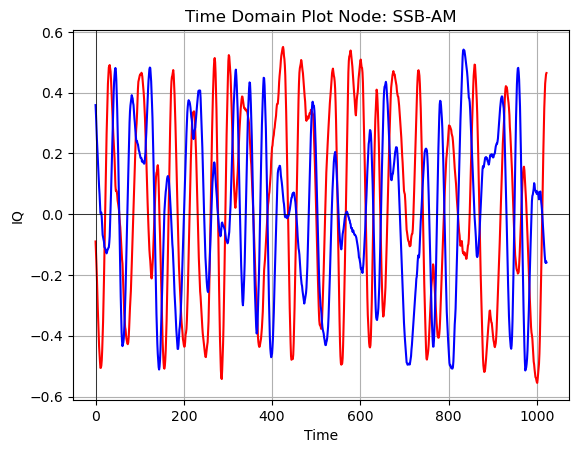

[[1.97061644e-10 6.65542825e-10 9.91373139e-11 ... 3.71280422e-14
  5.06055873e-11 1.94860370e-10]
 [1.21540853e-10 5.76981987e-10 1.12421565e-10 ... 1.77895606e-13
  4.32325186e-11 9.66237156e-11]
 [3.51109886e-10 6.95344222e-11 1.76207594e-11 ... 6.13939076e-13
  1.36915394e-10 7.68012047e-10]
 ...
 [1.84511631e-10 4.30719261e-10 9.89049646e-11 ... 9.79994829e-13
  1.78466143e-10 8.10759570e-10]
 [4.02517102e-10 1.12537827e-10 3.28948199e-11 ... 2.37250605e-12
  1.42976285e-10 7.89083008e-10]
 [1.31437779e-10 1.10464784e-10 1.77341166e-11 ... 1.35967075e-12
  1.04909211e-11 1.11373095e-10]]
(42, 32)


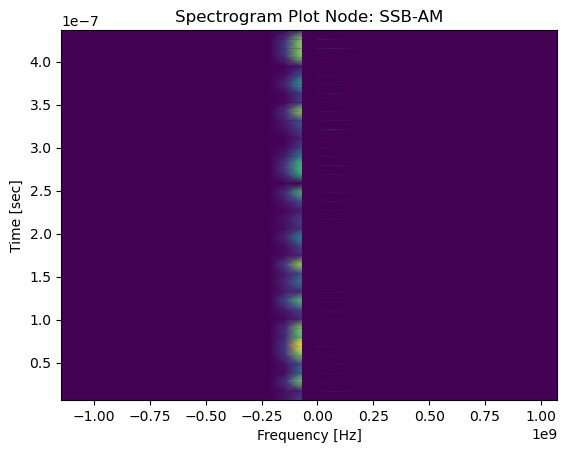

[[5.19307762e-10 2.12760385e-09 1.48176824e-09 ... 1.69006933e-10
  1.12723821e-10 2.54318422e-10]
 [3.03794589e-10 1.31742890e-10 2.00641700e-11 ... 5.57126520e-11
  1.16859098e-09 2.73519570e-09]
 [5.84983092e-11 1.51415486e-09 9.11540579e-10 ... 1.59146920e-10
  6.98183656e-10 4.06585551e-10]
 ...
 [4.52015981e-10 1.40626343e-10 1.13376147e-12 ... 4.44043038e-11
  1.68776169e-11 3.47922486e-10]
 [9.05198064e-11 2.29933327e-10 4.09193228e-10 ... 1.76520364e-10
  1.85417502e-09 1.56953932e-09]
 [6.17329043e-10 4.08173714e-10 4.04207582e-10 ... 7.60958622e-11
  3.27457121e-10 1.68709799e-09]]
(21, 64)


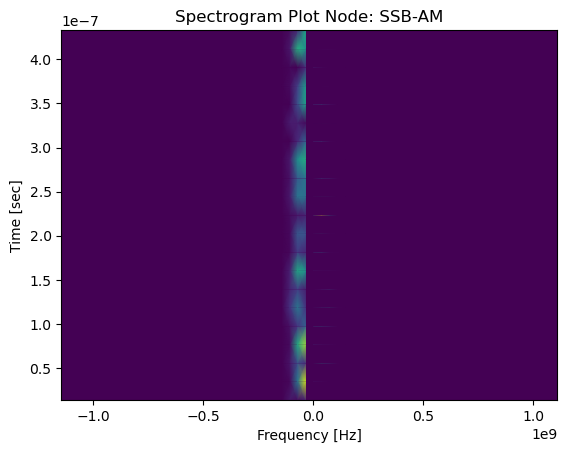

[[9.47308493e-11 1.77056453e-10 1.15014086e-09 ... 1.88190532e-09
  2.84490713e-09 1.11494119e-09]
 [6.85458857e-10 8.46813363e-10 3.49792369e-10 ... 4.26139284e-09
  1.16329628e-09 1.52113519e-10]
 [5.23344835e-11 8.68087435e-10 1.45661061e-09 ... 8.09397973e-10
  9.71380147e-11 4.02552873e-11]
 ...
 [1.65352896e-10 9.41146284e-10 2.61284583e-09 ... 1.10246447e-10
  2.90673279e-11 8.15704260e-10]
 [4.14199081e-10 1.38293277e-09 1.21385512e-09 ... 1.07813166e-09
  3.64835108e-09 6.72299910e-10]
 [3.53326072e-10 3.02413141e-10 4.40721179e-10 ... 2.50255023e-09
  2.59503875e-09 2.27739699e-09]]
(10, 128)


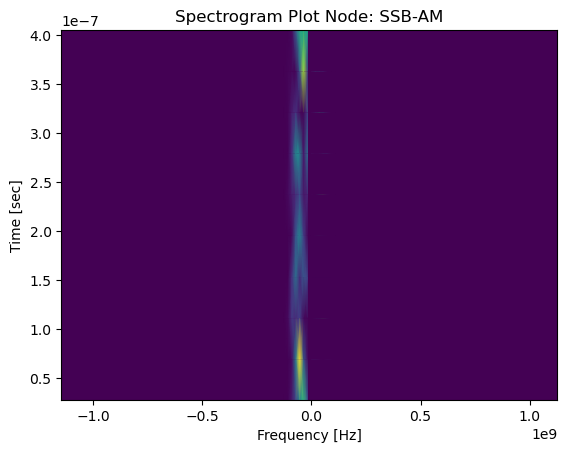

[[1.74299446e-10 1.64897988e-10 1.06221273e-09 ... 7.99670941e-10
  1.53329982e-09 1.06964272e-09]
 [1.23942602e-10 2.67805412e-10 1.59675105e-09 ... 9.97030660e-10
  6.98209487e-10 4.08612187e-10]
 [2.11100513e-11 1.17856777e-10 1.36514807e-10 ... 1.97852449e-10
  4.30563880e-10 1.08955746e-10]
 [1.81677852e-11 1.03049586e-10 1.80845202e-10 ... 1.24198232e-09
  3.33401027e-09 1.40368455e-09]
 [3.39341877e-10 6.99178042e-10 9.74007007e-10 ... 3.49586213e-09
  1.12054680e-09 4.44896118e-10]]
(5, 256)


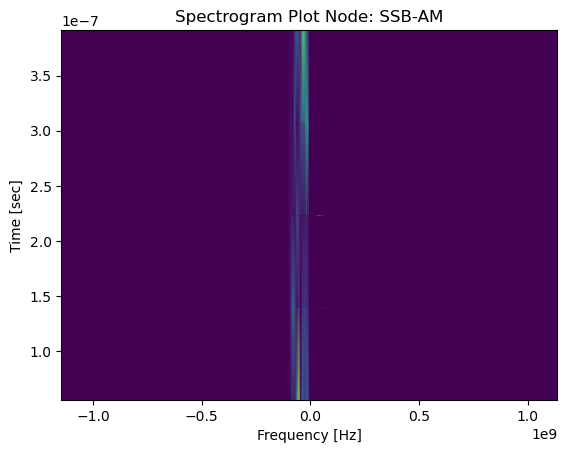

[[6.68682217e-11 2.24827668e-10 6.81514482e-11 ... 8.90791371e-10
  1.03410363e-09 5.02215002e-10]
 [9.61171363e-11 2.54516841e-10 3.70654729e-10 ... 7.64908179e-10
  5.77097004e-10 3.43988497e-10]]
(2, 512)


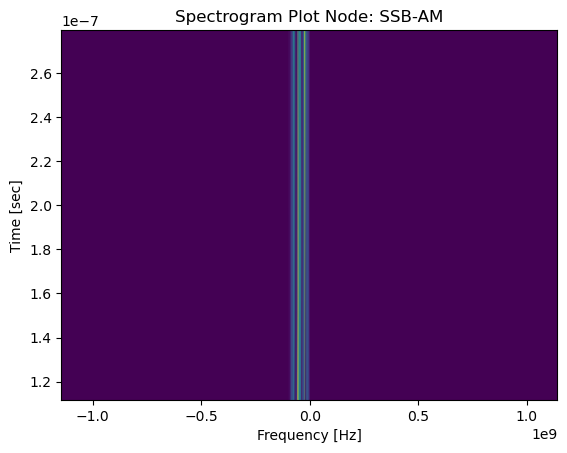

(11000,)
1
(11000, 2, 1024)


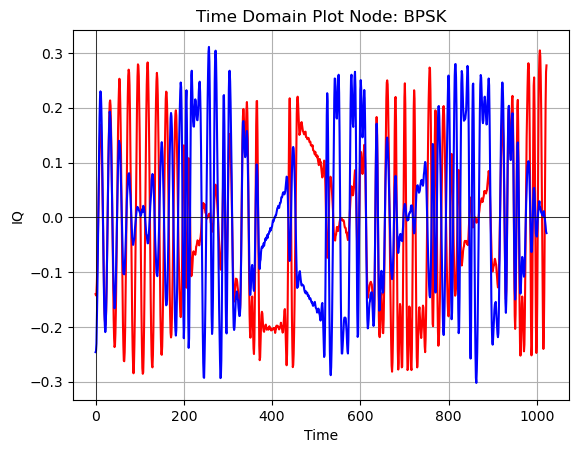

[[9.46439689e-12 1.66622909e-10 1.29567722e-10 ... 7.70643346e-12
  1.43181792e-10 1.35669633e-10]
 [2.80976628e-11 1.75831482e-10 1.33042539e-10 ... 7.37924938e-12
  1.46403606e-10 1.46732784e-10]
 [1.03734814e-10 2.16454450e-10 1.32498971e-10 ... 7.26894854e-12
  1.49284322e-10 1.85635062e-10]
 ...
 [2.24201524e-12 1.17973937e-11 1.12209310e-10 ... 1.27314764e-10
  8.89810818e-11 1.53793905e-11]
 [4.45713478e-11 1.88287019e-10 1.21818951e-10 ... 1.46188138e-11
  1.31594437e-10 1.80454415e-10]
 [4.19988947e-12 2.51048869e-11 1.32019430e-10 ... 1.10611920e-10
  1.11688204e-10 2.04576952e-11]]
(42, 32)


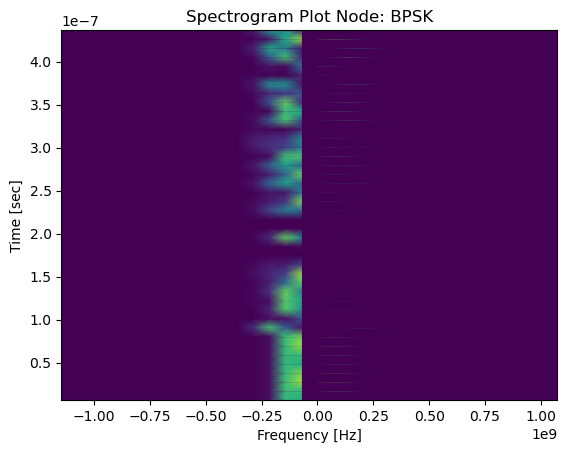

[[2.67515140e-13 1.43628018e-13 1.29987764e-10 ... 3.77239948e-10
  6.76713852e-11 8.07900191e-14]
 [2.15739186e-12 4.22739020e-14 1.30264954e-10 ... 3.69801557e-10
  6.60667832e-11 1.24674546e-13]
 [1.57613908e-13 1.27522039e-13 1.29769523e-10 ... 3.74710172e-10
  6.67308194e-11 8.67134912e-14]
 ...
 [1.74668583e-11 3.05082835e-10 1.64184724e-10 ... 3.22642752e-11
  2.24004175e-10 2.73743268e-10]
 [6.20167124e-11 8.85943080e-11 6.05594679e-11 ... 9.01298952e-11
  6.62486759e-11 1.06587938e-10]
 [2.20365077e-11 3.50351835e-12 6.11773079e-11 ... 3.65232353e-11
  3.64688546e-11 9.53199435e-12]]
(21, 64)


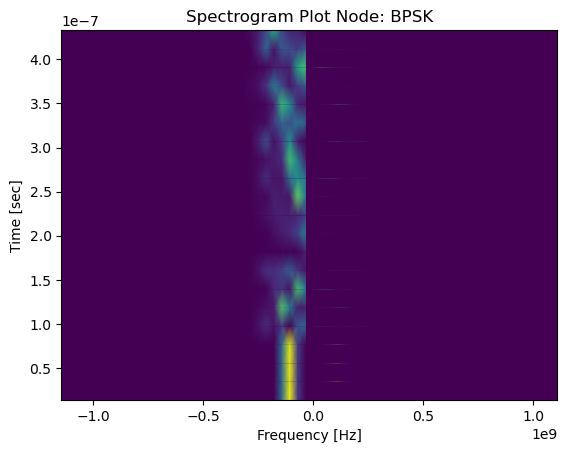

[[4.30642699e-13 9.43441449e-14 5.84542231e-16 ... 3.32703180e-14
  2.80268849e-14 1.46914099e-13]
 [5.73752005e-12 2.74239615e-12 6.37865072e-13 ... 4.80196317e-13
  3.66300386e-13 4.13777970e-12]
 [5.14819515e-12 1.46570077e-11 2.35271466e-11 ... 1.09795927e-10
  4.65073798e-12 4.50364159e-11]
 ...
 [1.66346363e-11 3.32125327e-11 7.12471627e-11 ... 9.16541155e-11
  7.59871275e-11 9.06806291e-11]
 [9.86160132e-12 2.37645214e-11 6.27972681e-11 ... 7.01917262e-11
  7.51011902e-11 2.61225106e-11]
 [6.19927833e-12 6.96594239e-11 2.49900560e-10 ... 1.24025526e-10
  2.02293601e-10 5.33137695e-12]]
(10, 128)


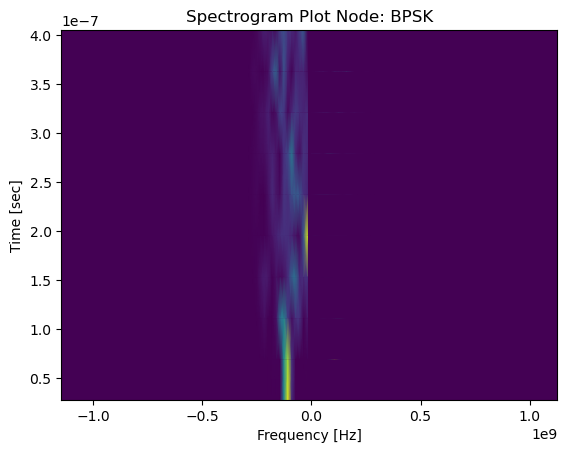

[[6.34784383e-12 9.49953217e-12 1.73816394e-12 ... 1.39731651e-12
  2.38206128e-12 1.09111555e-11]
 [6.49152390e-11 2.36356774e-11 3.18087382e-11 ... 3.59276822e-11
  2.42186178e-11 3.31524947e-10]
 [3.01485208e-10 4.74372880e-10 1.95379255e-10 ... 1.68653884e-10
  4.55947670e-10 3.24253621e-10]
 [7.98614224e-11 1.37089465e-11 5.17991316e-11 ... 5.50466214e-11
  6.58356435e-11 1.54353826e-10]
 [2.31830688e-12 2.39990247e-11 1.89672599e-11 ... 1.90022996e-11
  1.63686797e-11 3.53534174e-11]]
(5, 256)


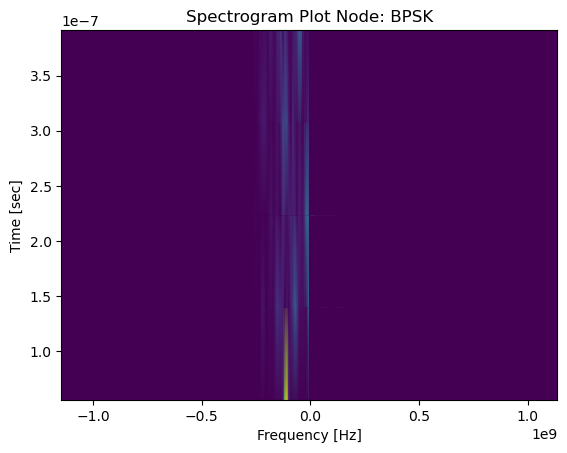

[[8.16197372e-11 2.40123229e-10 1.82539104e-11 ... 1.64714871e-10
  2.12988066e-10 3.78377766e-11]
 [2.19312486e-11 1.06575238e-10 1.51437147e-10 ... 1.60269393e-10
  3.97000897e-11 2.97843217e-10]]
(2, 512)


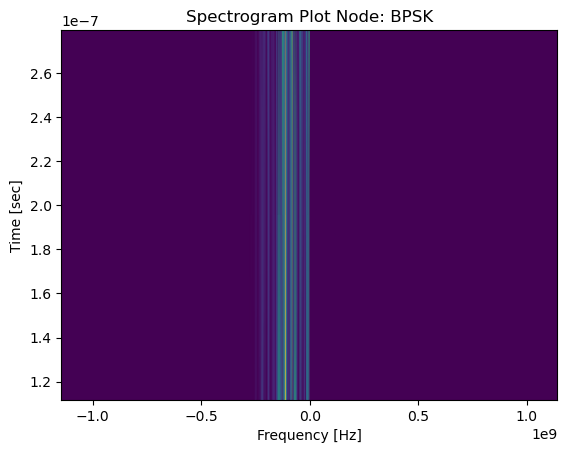

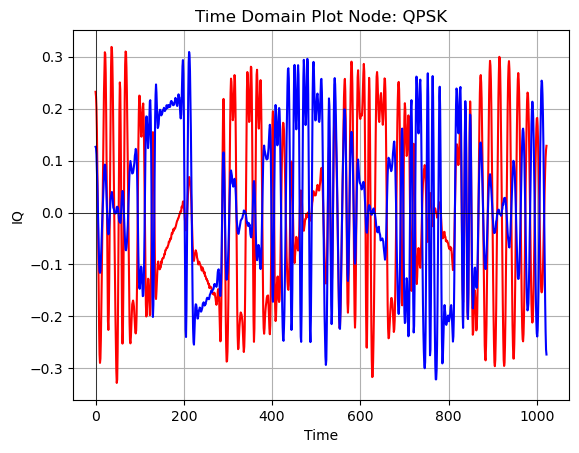

[[1.02234345e-12 1.77346011e-10 1.49910457e-10 ... 5.89577957e-12
  1.66262394e-10 1.45288569e-10]
 [1.20622607e-11 1.68277999e-10 1.55963065e-10 ... 9.30153237e-12
  1.73693128e-10 1.46870229e-10]
 [3.83664850e-11 5.02861533e-11 1.65193779e-10 ... 8.49184070e-11
  1.51690555e-10 4.51865138e-11]
 ...
 [1.31700719e-11 1.84759546e-10 1.40417451e-10 ... 8.45066615e-12
  1.56029678e-10 1.47841003e-10]
 [2.63107298e-11 1.90517575e-10 1.44038989e-10 ... 8.21596395e-12
  1.57404675e-10 1.55543500e-10]
 [1.11785077e-10 2.37624540e-10 1.45208133e-10 ... 8.02390395e-12
  1.63722194e-10 2.01617992e-10]]
(42, 32)


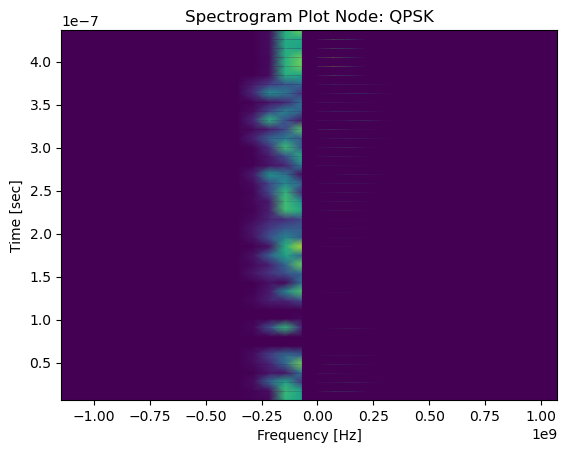

[[1.88998041e-11 4.93990848e-11 7.14636224e-12 ... 1.61201118e-10
  1.91086666e-11 4.86185208e-11]
 [6.45233193e-11 2.04150661e-10 2.31770736e-10 ... 5.90003345e-11
  2.52436041e-10 1.36795391e-10]
 [3.07905394e-11 1.00046282e-12 1.15562492e-10 ... 1.71820458e-10
  6.33765923e-11 3.43709535e-11]
 ...
 [3.18453814e-13 2.00728323e-13 1.46844998e-10 ... 4.08386353e-10
  7.03421077e-11 4.14107275e-14]
 [2.23370454e-12 1.28491770e-13 1.44144219e-10 ... 4.04481031e-10
  6.96048821e-11 1.41417996e-13]
 [3.76724993e-13 1.55968403e-13 1.46182601e-10 ... 4.07452049e-10
  7.04841988e-11 1.07884926e-13]]
(21, 64)


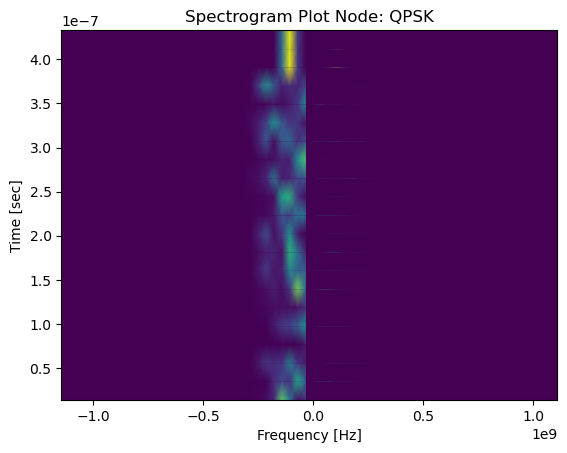

[[2.21120453e-12 1.29978434e-11 2.86026640e-11 ... 1.32376733e-10
  1.78517826e-11 2.59791663e-11]
 [1.90179717e-10 4.70027712e-11 3.02585743e-12 ... 4.76843060e-12
  4.62292246e-11 2.77551367e-10]
 [3.27901408e-10 1.46905717e-10 1.16918277e-12 ... 1.49454043e-11
  6.56270048e-11 3.94242288e-10]
 ...
 [3.15321577e-11 9.11471961e-11 1.00630194e-10 ... 1.07488757e-10
  8.91908657e-11 3.37680682e-11]
 [2.65311905e-11 1.41766863e-10 2.32859149e-10 ... 1.50273407e-10
  1.78169100e-10 4.36284276e-11]
 [4.77780695e-13 9.87496408e-14 1.41034410e-15 ... 6.58573078e-14
  1.36344175e-14 1.14144100e-13]]
(10, 128)


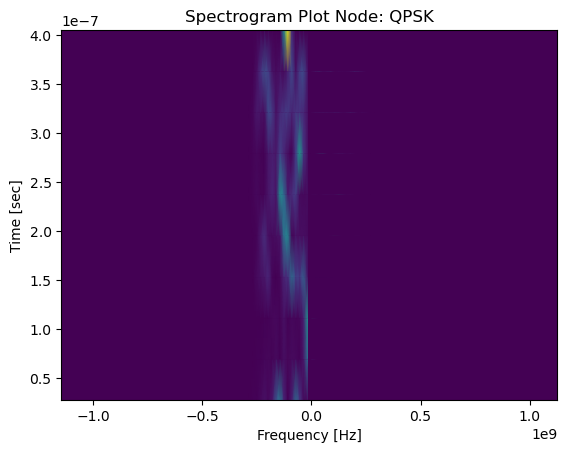

[[1.79816139e-10 2.32543984e-10 1.17202469e-10 ... 1.07583785e-10
  2.64563974e-10 3.47287698e-10]
 [9.34087850e-12 2.56452205e-10 1.35105242e-11 ... 3.25249466e-12
  1.90944746e-10 1.30069926e-10]
 [1.29779446e-11 4.61115744e-11 8.75940535e-11 ... 7.75332449e-11
  7.59669766e-11 1.03237071e-10]
 [1.49360577e-11 3.90206630e-11 1.45547714e-11 ... 2.35968256e-11
  9.13125179e-12 8.82048296e-13]
 [2.78103678e-11 3.74384287e-12 1.00043316e-11 ... 1.06642339e-11
  2.82955086e-12 2.26448471e-11]]
(5, 256)


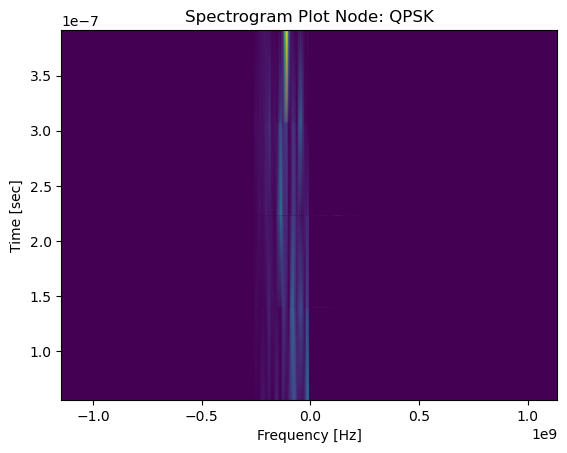

[[1.35205668e-10 6.27302572e-10 9.15020811e-10 ... 7.74929993e-10
  4.07331355e-10 1.54314479e-10]
 [7.17325809e-11 2.42072202e-12 4.78342956e-11 ... 1.95127629e-11
  4.78338177e-11 3.16102871e-10]]
(2, 512)


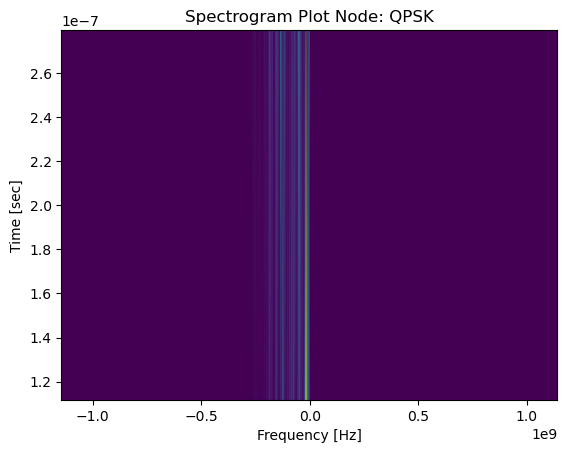

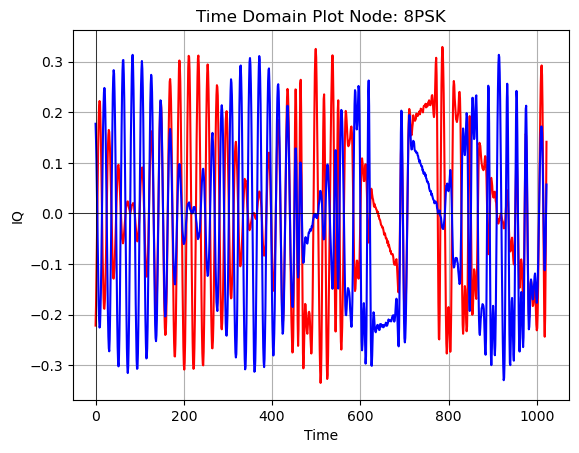

[[1.88646607e-11 2.07710371e-10 1.58451653e-10 ... 9.52385107e-12
  1.74541995e-10 1.64283789e-10]
 [1.13378534e-10 2.57858775e-10 1.60744194e-10 ... 8.79530427e-12
  1.78539004e-10 2.14525262e-10]
 [1.14306792e-10 2.60283571e-10 1.60805760e-10 ... 9.16737944e-12
  1.79568797e-10 2.18057862e-10]
 ...
 [3.46467854e-11 1.23094273e-10 1.56309082e-10 ... 8.57559795e-11
  1.44832990e-10 8.76855713e-11]
 [5.96788147e-11 1.45586148e-10 1.82906168e-10 ... 8.89020689e-11
  1.69104155e-10 9.86736454e-11]
 [2.53635972e-11 1.15864861e-10 4.60245768e-11 ... 1.63932674e-11
  5.45028014e-11 1.50929765e-10]]
(42, 32)


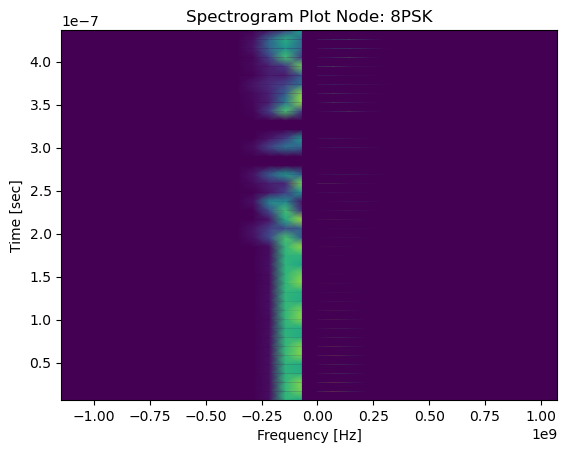

[[2.63663741e-13 7.23942169e-14 1.59992583e-10 ... 4.48570700e-10
  7.84363599e-11 3.18761914e-14]
 [2.85845276e-12 1.23358335e-13 1.60829759e-10 ... 4.46699654e-10
  7.76499111e-11 1.73912195e-13]
 [3.57565920e-13 2.29528384e-13 1.67503325e-10 ... 4.51193636e-10
  7.83577374e-11 3.00142542e-14]
 ...
 [7.41384679e-14 2.72519471e-12 1.46106658e-10 ... 2.28838146e-10
  8.37921817e-11 2.14153715e-11]
 [2.48126440e-11 6.06647514e-12 6.89877791e-11 ... 2.11493697e-10
  4.12913292e-11 1.92461000e-11]
 [2.35254613e-11 9.96449585e-11 1.18257144e-10 ... 2.07893074e-12
  1.62643144e-10 1.21951846e-10]]
(21, 64)


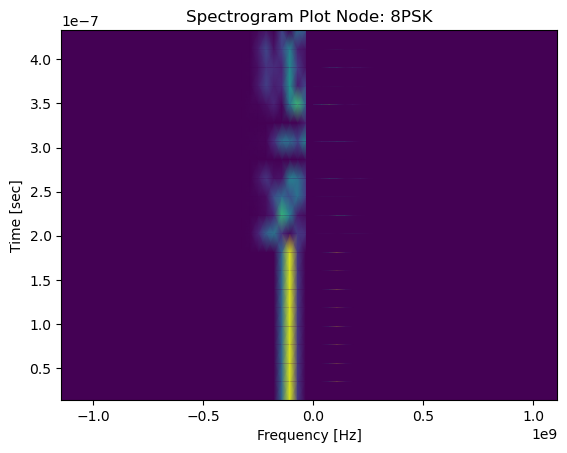

[[5.75279376e-13 1.39536011e-13 9.34061899e-15 ... 5.10082139e-14
  1.04813476e-14 1.28547857e-13]
 [7.15778956e-13 1.51895359e-13 3.07588356e-14 ... 5.77888579e-14
  3.34041657e-14 2.35975629e-13]
 [8.75529622e-13 1.82498048e-13 1.15048842e-14 ... 2.26576022e-14
  5.20655163e-15 1.83217653e-13]
 ...
 [3.20794974e-10 1.77852112e-10 1.56940483e-11 ... 2.80629216e-11
  1.12139125e-10 4.81588569e-10]
 [2.75797304e-11 8.90084681e-11 2.84113257e-10 ... 2.18574575e-10
  2.09672700e-10 4.31248840e-11]
 [1.11891533e-11 6.36980856e-11 4.46850680e-11 ... 4.05046731e-11
  3.70140972e-11 7.20224479e-12]]
(10, 128)


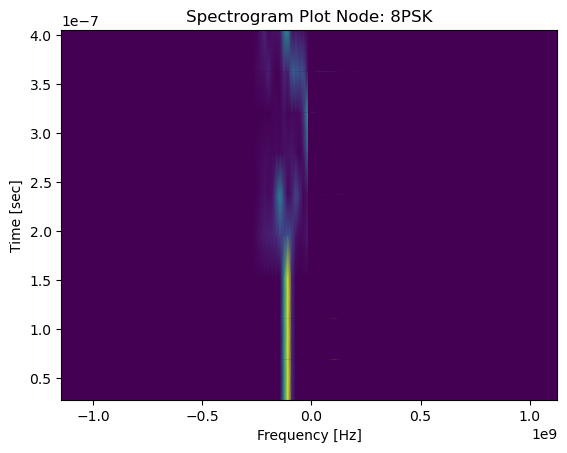

[[6.73583595e-13 1.90578210e-13 1.18483924e-15 ... 1.80964720e-14
  1.66138124e-14 1.32172936e-13]
 [1.05052686e-12 3.39442804e-13 1.09870962e-14 ... 6.58467066e-15
  6.01891067e-15 2.22163577e-13]
 [3.21898278e-11 4.25038211e-11 2.44134196e-11 ... 2.05788818e-11
  1.01246215e-10 1.20197580e-10]
 [2.60893918e-12 7.04783640e-10 3.42251599e-10 ... 2.82079388e-10
  1.21146069e-09 9.13476294e-10]
 [8.27784260e-12 1.79903592e-11 6.18400174e-11 ... 7.55309766e-11
  6.19099844e-11 1.31916763e-10]]
(5, 256)


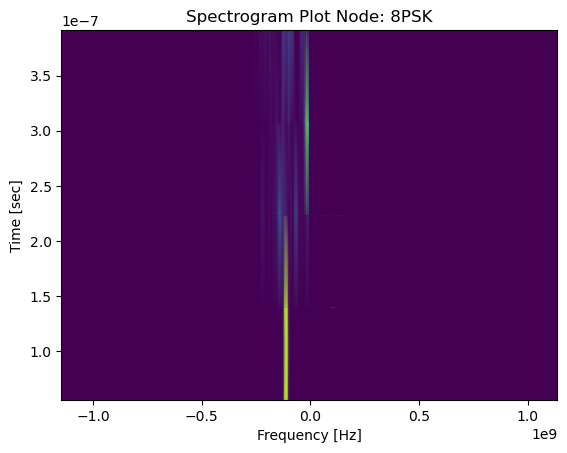

[[1.17511075e-11 4.98423849e-12 1.21738145e-13 ... 9.27749149e-14
  7.70811434e-14 5.41945147e-12]
 [9.51338036e-11 6.88950896e-10 5.84049233e-10 ... 9.62717369e-10
  5.27611990e-10 3.10904142e-11]]
(2, 512)


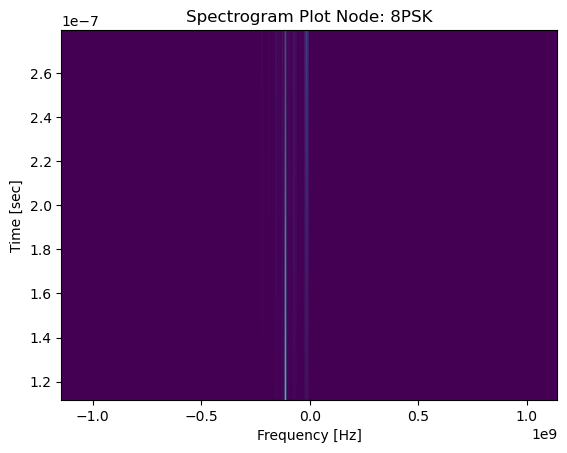

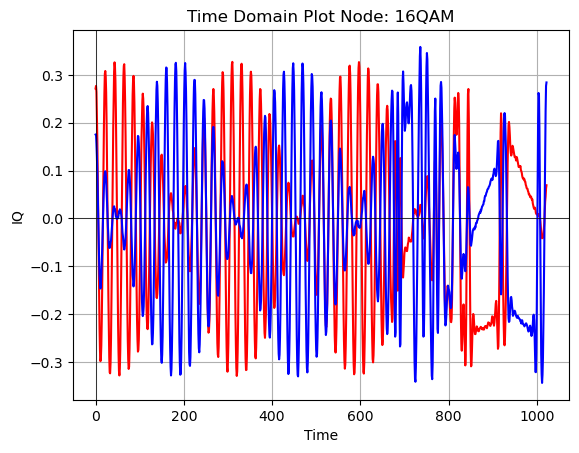

[[1.23173056e-11 2.21152381e-10 1.69149275e-10 ... 1.05236002e-11
  1.90971194e-10 1.76453567e-10]
 [3.79841570e-11 2.31296324e-10 1.71155148e-10 ... 9.74089994e-12
  1.92251029e-10 1.91100659e-10]
 [1.37754861e-10 2.87278445e-10 1.73153713e-10 ... 1.00938731e-11
  2.00773319e-10 2.45269608e-10]
 ...
 [1.49094018e-13 1.06012140e-12 3.22264543e-14 ... 1.27687038e-13
  8.38134833e-14 7.98532606e-13]
 [4.97591594e-14 1.09251969e-12 1.25150678e-13 ... 3.60110750e-14
  4.34866461e-14 9.32763327e-13]
 [2.81526945e-11 1.19308901e-10 1.36160452e-10 ... 6.94866373e-11
  1.38607375e-10 9.99452433e-11]]
(42, 32)


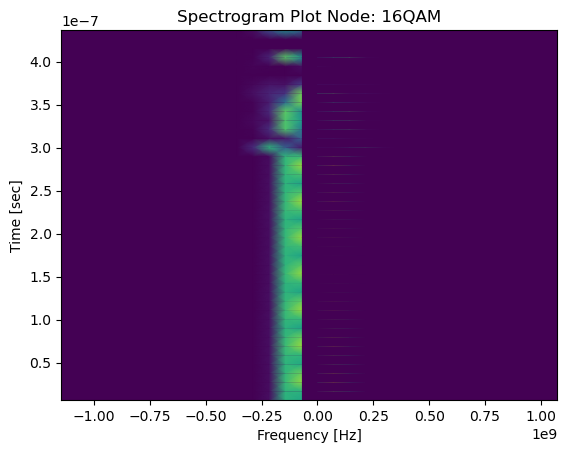

[[3.65056137e-13 2.55890970e-13 1.77171590e-10 ... 4.92860092e-10
  8.39990527e-11 9.08619418e-14]
 [3.54669454e-12 7.32637391e-14 1.76986755e-10 ... 4.92823361e-10
  8.38708479e-11 1.80308793e-13]
 [2.32101279e-13 2.42605441e-13 1.80108259e-10 ... 4.98487064e-10
  8.47027850e-11 1.22368404e-13]
 ...
 [1.46319719e-11 2.88528129e-12 3.71253111e-12 ... 4.25156317e-12
  4.99272963e-12 4.85194085e-11]
 [3.74611488e-11 1.06254863e-10 6.22231499e-11 ... 5.33038488e-11
  8.84467814e-11 2.09048330e-10]
 [1.77269320e-11 3.60772010e-11 4.28469524e-11 ... 4.76840046e-11
  5.29129233e-11 9.10015130e-11]]
(21, 64)


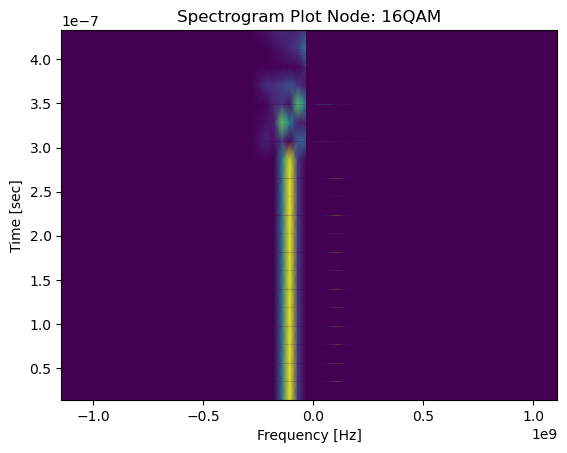

[[5.60157380e-13 1.98207433e-13 2.54551307e-14 ... 5.64241281e-14
  1.03119608e-14 9.48560522e-14]
 [3.37791096e-13 6.97616388e-14 6.65141881e-14 ... 4.04352280e-14
  1.94314865e-15 8.78282846e-14]
 [2.60545092e-13 6.92445962e-14 5.44213882e-15 ... 3.60883578e-14
  2.60395944e-16 6.22736362e-14]
 ...
 [8.55424890e-12 1.81658772e-11 2.94773081e-11 ... 1.34616538e-10
  5.22324868e-12 6.24799902e-11]
 [2.01852901e-11 1.27283711e-10 1.04142022e-10 ... 1.04085577e-10
  1.27898427e-10 1.49361919e-10]
 [4.34081519e-11 2.87291457e-10 7.63381670e-11 ... 1.71328124e-11
  2.84554094e-10 9.35380366e-10]]
(10, 128)


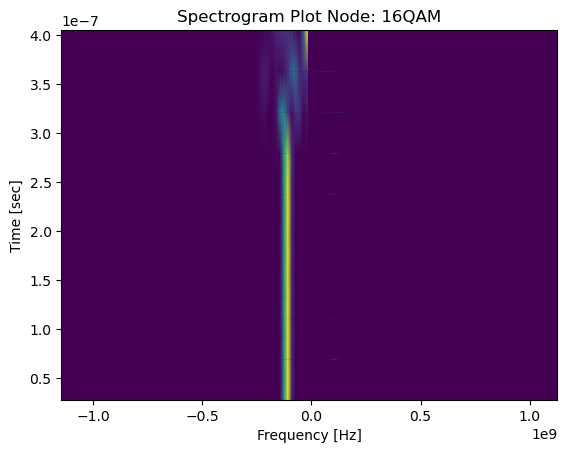

[[3.45387842e-13 4.26910119e-14 1.91578576e-14 ... 9.62539834e-15
  2.45421276e-16 6.94810173e-14]
 [2.19197883e-13 5.46894426e-14 1.26038189e-14 ... 4.16817714e-15
  9.17317363e-15 6.85814776e-14]
 [3.87755916e-14 5.89335149e-15 2.13189761e-14 ... 6.89198371e-15
  2.54107683e-15 1.11595718e-14]
 [3.81381155e-11 6.85110206e-11 5.38872926e-11 ... 4.97086098e-11
  1.18582313e-10 8.17524650e-11]
 [2.17941794e-10 7.14923191e-10 2.73427574e-10 ... 2.31013611e-10
  1.10057923e-09 8.59229869e-10]]
(5, 256)


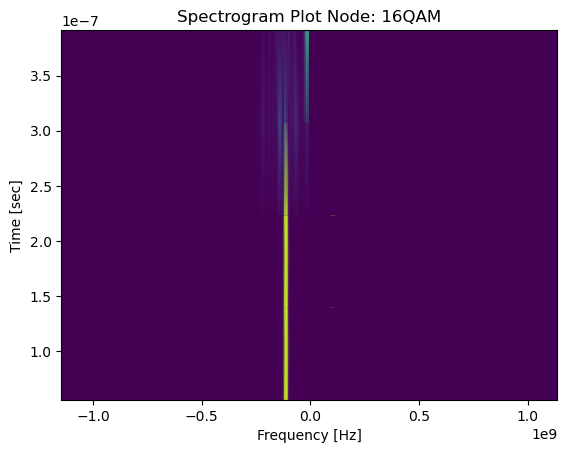

[[1.99222040e-14 2.98782162e-14 5.11726080e-15 ... 1.03219864e-14
  1.82908706e-15 8.02167752e-15]
 [6.59239280e-11 1.07375676e-10 4.69549786e-11 ... 6.29283590e-11
  5.43534041e-11 1.57036882e-12]]
(2, 512)


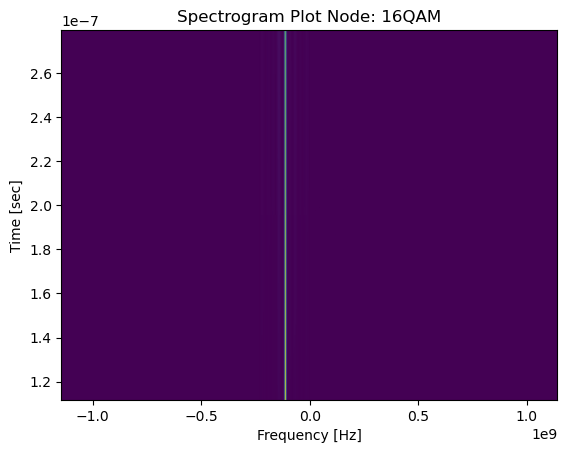

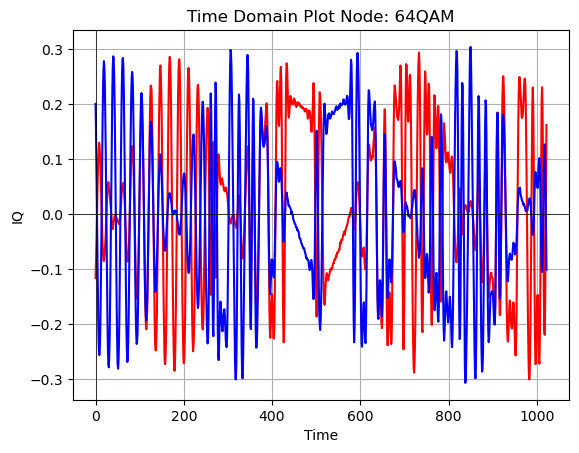

[[3.46481709e-11 1.83890135e-10 1.32331176e-10 ... 8.23170329e-12
  1.49880808e-10 1.47687101e-10]
 [1.07079317e-10 2.21866365e-10 1.33848387e-10 ... 7.50198553e-12
  1.49698745e-10 1.85790287e-10]
 [7.55080609e-11 2.06007314e-10 1.32154658e-10 ... 8.13743367e-12
  1.49560807e-10 1.70574049e-10]
 ...
 [1.87471474e-11 1.05873929e-10 4.77677607e-11 ... 1.83736488e-11
  5.36285925e-11 1.35989557e-10]
 [8.01793499e-12 1.47280662e-10 8.43917188e-11 ... 1.25123456e-11
  9.69669173e-11 1.60552422e-10]
 [4.26610613e-11 9.75082419e-11 2.34811182e-11 ... 2.75577198e-11
  3.64480488e-11 9.39077926e-11]]
(42, 32)


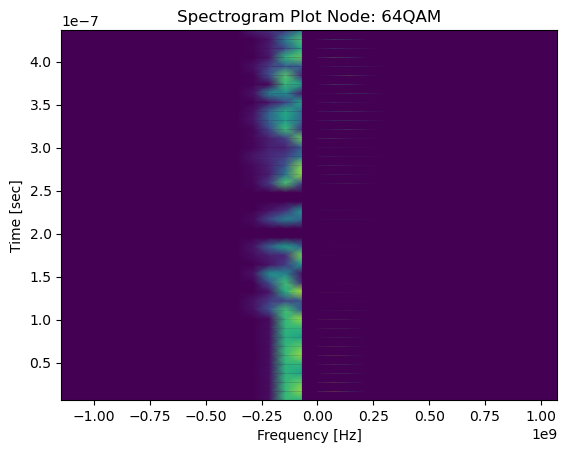

[[8.61675691e-13 1.03726153e-13 1.35894521e-10 ... 3.73627646e-10
  6.40927490e-11 7.49978597e-14]
 [2.28607522e-12 1.79945953e-13 1.36869959e-10 ... 3.69479974e-10
  6.21259525e-11 1.32140900e-13]
 [8.67846769e-13 1.12951839e-13 1.38067469e-10 ... 3.71833211e-10
  6.35701300e-11 1.23040983e-13]
 ...
 [8.14090162e-11 7.18333763e-11 9.85663415e-11 ... 7.56838512e-11
  9.46088029e-11 9.06666103e-11]
 [1.66692031e-10 2.94823448e-10 8.97760128e-11 ... 9.26126189e-12
  1.65114680e-10 2.70629418e-10]
 [8.41042350e-11 5.68072342e-11 2.30001802e-11 ... 1.77111753e-10
  3.03832199e-12 9.51462766e-11]]
(21, 64)


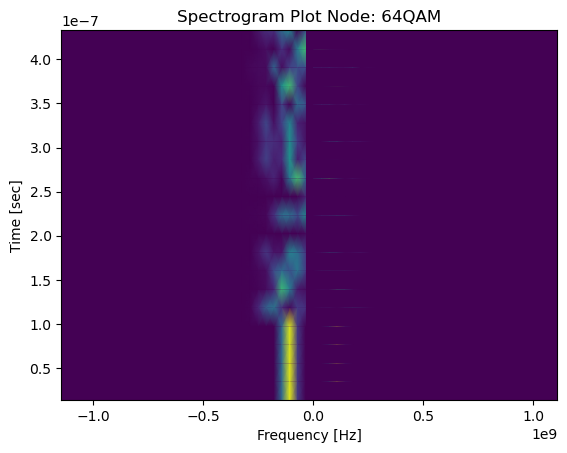

[[1.39878263e-12 3.84593301e-13 3.14617182e-14 ... 4.97535187e-14
  1.06001995e-14 3.07796293e-13]
 [1.16008407e-12 1.66934946e-13 8.04020681e-15 ... 5.43796179e-14
  1.44540389e-14 1.82277273e-13]
 [2.86520604e-12 2.99287858e-11 1.33777182e-11 ... 1.36816213e-11
  2.48555911e-11 5.45338996e-11]
 ...
 [1.00994250e-11 5.45967628e-11 3.67108270e-11 ... 3.48873365e-11
  3.25327394e-11 6.82545429e-12]
 [2.94226028e-11 8.20694267e-11 2.46088056e-11 ... 4.65030141e-11
  2.99959765e-11 3.01947046e-11]
 [1.06072363e-11 8.36762129e-12 2.42491024e-10 ... 3.52482137e-10
  7.21226030e-11 2.91568386e-11]]
(10, 128)


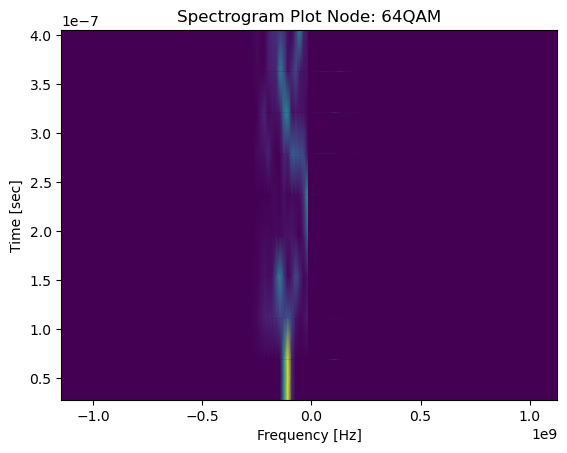

[[1.23986692e-12 2.20009517e-13 2.39221003e-14 ... 2.58671846e-14
  2.37452551e-14 2.23290700e-13]
 [2.37614998e-11 3.29609609e-11 1.93859756e-11 ... 1.84577859e-11
  8.95298541e-11 1.00863894e-10]
 [3.17377091e-12 5.66054460e-10 2.72800363e-10 ... 2.43360460e-10
  1.01017106e-09 7.35009186e-10]
 [7.79011944e-12 1.31214816e-11 5.43659805e-11 ... 5.65927724e-11
  5.10686706e-11 1.10557899e-10]
 [2.54645389e-11 1.89208315e-11 1.56722541e-11 ... 1.51404167e-11
  6.07754094e-11 6.92758928e-11]]
(5, 256)


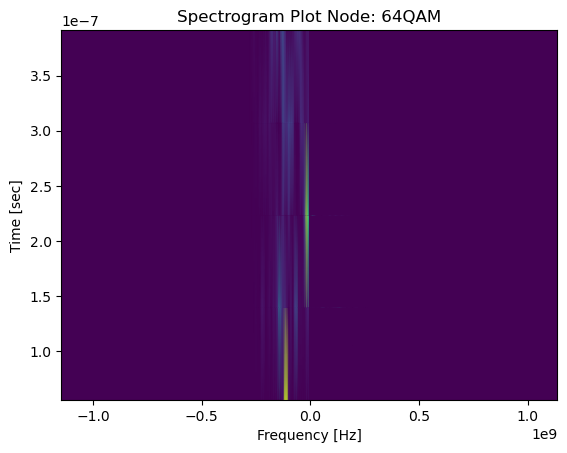

[[5.73267952e-11 9.55394052e-11 3.42121676e-11 ... 8.42122496e-11
  7.12640248e-11 1.72151353e-11]
 [7.44672166e-11 4.38995216e-10 3.66010680e-10 ... 2.44757500e-10
  1.02248675e-10 2.04244095e-10]]
(2, 512)


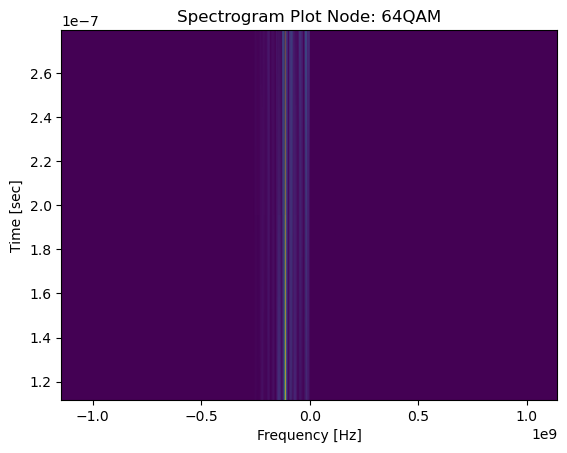

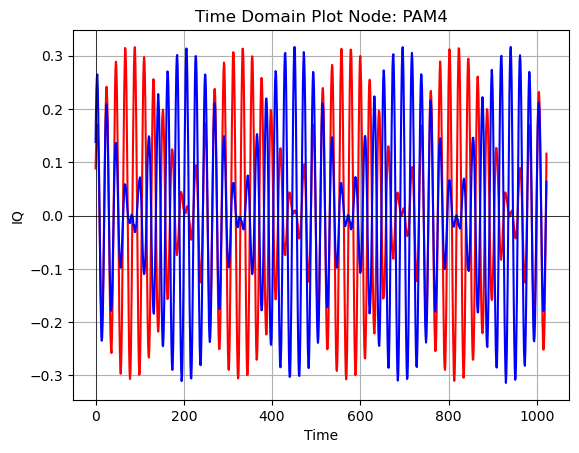

[[1.08172203e-10 2.60069374e-10 1.59199872e-10 ... 9.28873937e-12
  1.78302098e-10 2.09351632e-10]
 [1.57349842e-11 2.09867383e-10 1.55320819e-10 ... 1.06598030e-11
  1.76600384e-10 1.61788849e-10]
 [2.83079772e-11 2.13386597e-10 1.55447992e-10 ... 1.00223040e-11
  1.76720475e-10 1.67265983e-10]
 ...
 [1.31756135e-10 2.70269033e-10 1.58542381e-10 ... 8.90801450e-12
  1.79135470e-10 2.21596765e-10]
 [5.18938114e-11 2.27170652e-10 1.54225939e-10 ... 9.44093547e-12
  1.73155275e-10 1.78218776e-10]
 [4.17996288e-12 2.00223567e-10 1.54979570e-10 ... 9.40529737e-12
  1.71841521e-10 1.53745570e-10]]
(42, 32)


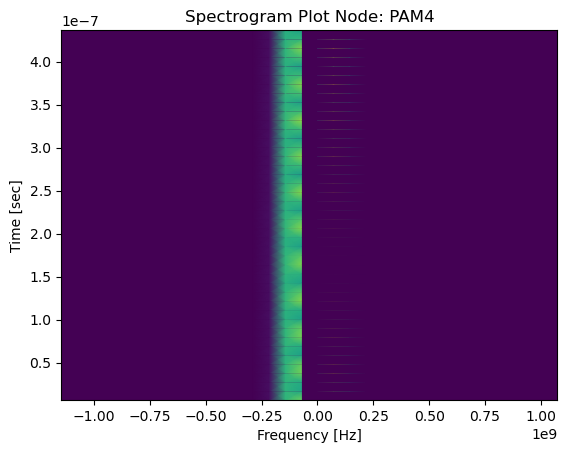

[[3.90045715e-12 2.23956808e-13 1.68206517e-10 ... 4.43753552e-10
  7.40049537e-11 3.90591140e-13]
 [7.80002161e-13 1.55623375e-13 1.65250076e-10 ... 4.37965026e-10
  7.01805873e-11 1.97948675e-13]
 [3.66966839e-12 2.49983289e-13 1.66274716e-10 ... 4.36300445e-10
  7.03429964e-11 3.48741099e-13]
 ...
 [1.93656603e-12 2.58217455e-13 1.68955131e-10 ... 4.42694889e-10
  7.37928649e-11 2.98823329e-13]
 [2.28133462e-12 1.13965195e-13 1.68611670e-10 ... 4.40615218e-10
  7.40163578e-11 1.22773643e-13]
 [1.60839013e-12 1.97262259e-13 1.68517253e-10 ... 4.38560537e-10
  7.23303642e-11 1.46505528e-13]]
(21, 64)


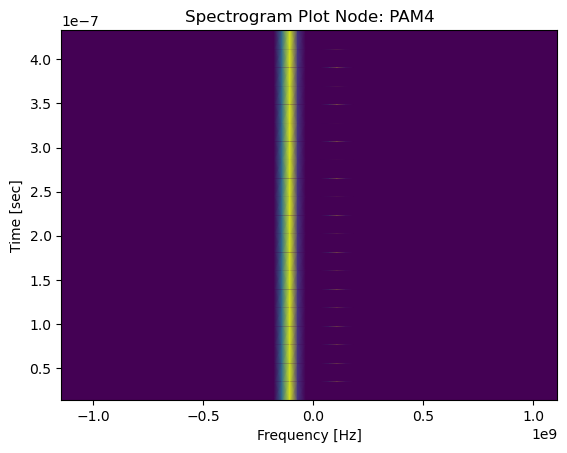

[[4.82844707e-12 9.61201837e-13 2.05134156e-14 ... 1.21477728e-13
  1.16005838e-14 8.30728446e-13]
 [4.61799565e-12 7.89704818e-13 5.41835082e-15 ... 1.05919903e-13
  2.72507829e-14 1.06028476e-12]
 [4.25506912e-12 7.39520724e-13 3.96508732e-14 ... 7.83814546e-14
  1.81704909e-14 9.85007414e-13]
 ...
 [3.26030242e-12 6.79331384e-13 1.69952126e-14 ... 3.14446655e-14
  2.24694355e-14 6.40659316e-13]
 [3.07007725e-12 6.26980508e-13 3.55746833e-15 ... 6.93979520e-14
  7.53453226e-15 5.81102723e-13]
 [2.93557132e-12 6.23159292e-13 2.32475766e-14 ... 5.87881697e-14
  2.53442431e-14 7.51093627e-13]]
(10, 128)


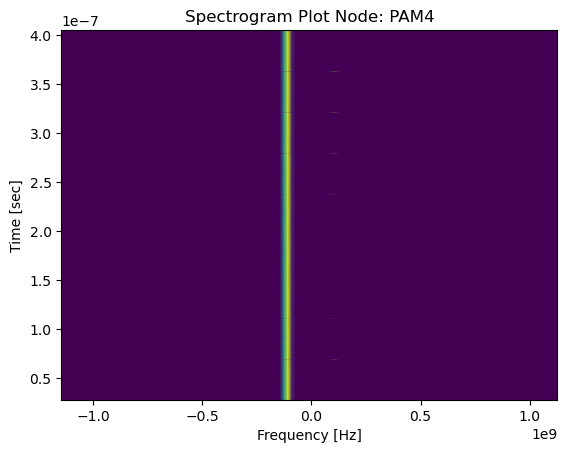

[[4.34184919e-12 1.06358391e-12 3.91405184e-15 ... 7.56803462e-15
  8.21163256e-17 9.47265755e-13]
 [3.83608533e-12 9.26111366e-13 5.11680335e-14 ... 1.07151115e-14
  1.34237479e-14 8.09211510e-13]
 [3.72939495e-12 7.43363328e-13 1.39013449e-15 ... 4.88486780e-15
  3.74564931e-14 1.27530067e-12]
 [3.04445951e-12 6.77206388e-13 4.76722581e-16 ... 6.77977402e-15
  1.13740416e-14 7.31430887e-13]
 [2.40852648e-12 5.34684483e-13 4.26593634e-16 ... 6.98910693e-15
  1.38675627e-14 5.47140391e-13]]
(5, 256)


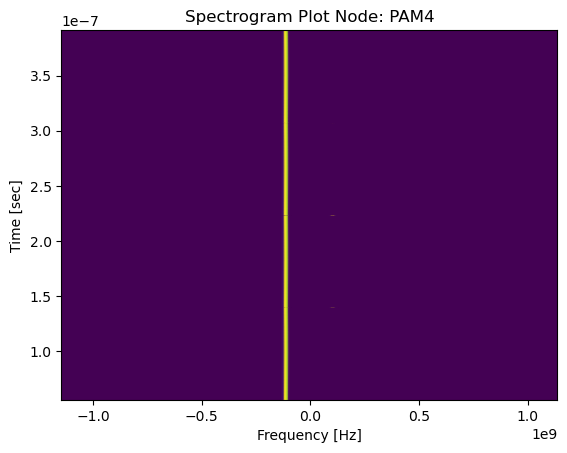

[[7.62744729e-14 8.34253022e-14 2.08834749e-14 ... 4.50201782e-15
  6.03306879e-15 4.11981663e-14]
 [3.11384279e-14 7.18266445e-15 7.15383410e-16 ... 2.15173558e-14
  1.19232466e-15 1.54557990e-14]]
(2, 512)


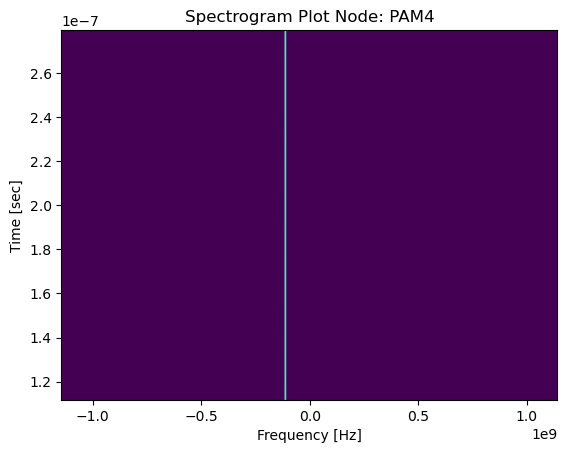

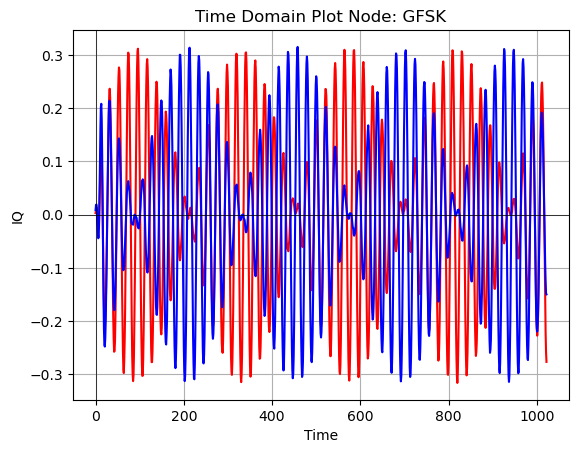

[[9.91236774e-12 1.12960658e-10 1.51624478e-10 ... 4.17680546e-11
  1.51548250e-10 8.89085047e-11]
 [6.59971276e-11 2.31569883e-10 1.56955897e-10 ... 8.83965259e-12
  1.78340373e-10 1.88702560e-10]
 [1.32684908e-10 2.68855921e-10 1.56626043e-10 ... 9.77925805e-12
  1.84162775e-10 2.24314111e-10]
 ...
 [1.96017689e-11 2.08670063e-10 1.52540062e-10 ... 1.00657743e-11
  1.72442986e-10 1.58970778e-10]
 [2.47180320e-11 2.09999543e-10 1.55880126e-10 ... 1.02010992e-11
  1.77310968e-10 1.64851297e-10]
 [1.18804973e-10 2.62531235e-10 1.59881970e-10 ... 9.50792604e-12
  1.82652269e-10 2.16810446e-10]]
(42, 32)


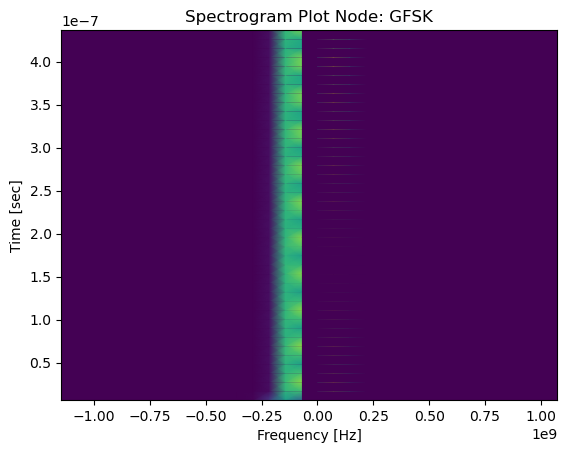

[[8.19977737e-13 1.02073741e-12 1.64702693e-10 ... 4.17335463e-10
  7.90526643e-11 2.05004096e-13]
 [4.25999736e-12 8.37216140e-14 1.66537054e-10 ... 4.43350383e-10
  7.20574393e-11 2.40430134e-13]
 [1.73044101e-14 4.02729844e-13 1.71165017e-10 ... 4.48140636e-10
  7.27123638e-11 1.56043493e-13]
 ...
 [6.35679484e-13 1.69675054e-13 1.65025073e-10 ... 4.47172795e-10
  7.30945952e-11 1.47077759e-13]
 [3.99389595e-12 1.99488123e-13 1.68997443e-10 ... 4.39835945e-10
  7.21890271e-11 5.30055086e-13]
 [7.19516815e-13 1.51349568e-13 1.68034750e-10 ... 4.47396447e-10
  7.41261719e-11 9.64518048e-14]]
(21, 64)


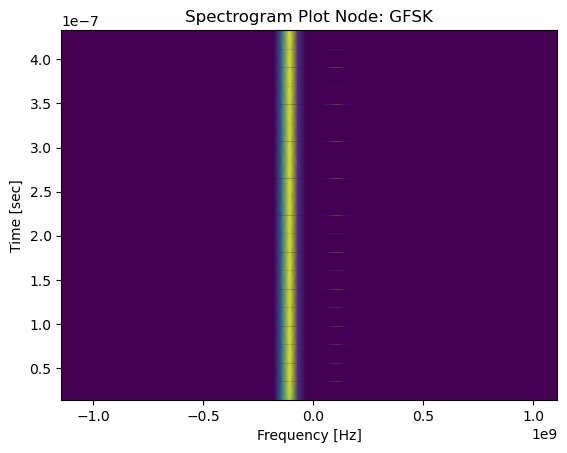

[[7.48450664e-14 4.15800925e-14 4.58900364e-14 ... 3.82077531e-14
  5.64373622e-14 1.77701185e-14]
 [1.28873393e-14 8.14193035e-15 2.99816902e-14 ... 4.14366489e-14
  1.92566451e-14 2.54159742e-14]
 [7.58641502e-15 3.15920448e-16 4.50546277e-14 ... 8.02088637e-14
  5.31007251e-14 1.83219150e-14]
 ...
 [3.07986983e-13 3.22160497e-14 2.11549457e-14 ... 4.84050171e-14
  1.73069551e-14 4.05459409e-14]
 [5.43596158e-13 1.25716490e-13 5.48047541e-15 ... 4.93844437e-14
  1.21897295e-14 6.67595341e-14]
 [6.04512928e-13 4.64740559e-14 2.32235745e-14 ... 1.05901688e-13
  6.90706377e-14 8.26332837e-14]]
(10, 128)


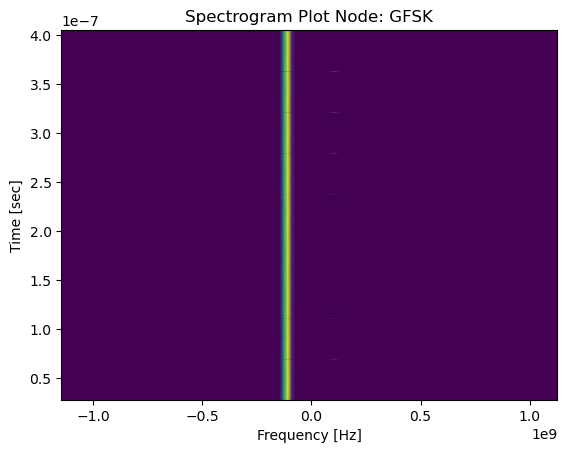

[[3.40004536e-15 1.85650200e-14 1.23872376e-15 ... 1.67760509e-14
  2.58146450e-14 1.19481659e-14]
 [4.70347677e-14 1.65910759e-14 9.15592709e-15 ... 1.83603140e-14
  1.96172224e-14 5.52329464e-14]
 [1.25078371e-13 4.65031985e-15 2.09840234e-14 ... 9.82957825e-15
  3.14685191e-14 1.18087707e-13]
 [3.41113070e-13 3.23264065e-14 2.28800513e-14 ... 1.61565173e-15
  2.78465035e-15 1.43221337e-13]
 [5.08540476e-13 1.18347807e-13 6.74767764e-15 ... 1.19447572e-14
  5.57881363e-15 1.12491334e-13]]
(5, 256)


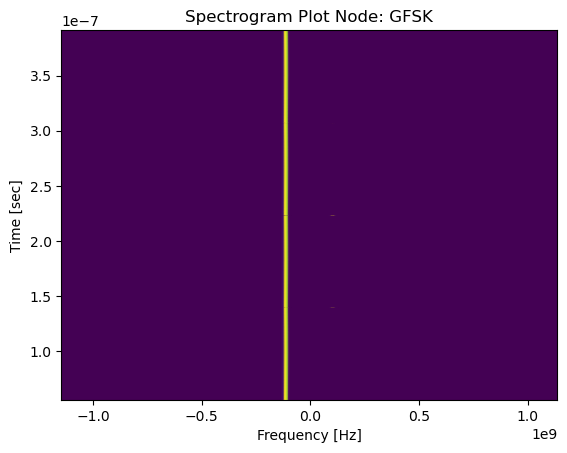

[[6.46087670e-15 1.73154609e-14 1.59987883e-14 ... 3.13949305e-16
  3.43256855e-14 9.56884396e-14]
 [1.83730192e-14 5.40012187e-14 2.87100604e-14 ... 1.57559110e-14
  3.06127050e-14 5.96702782e-14]]
(2, 512)


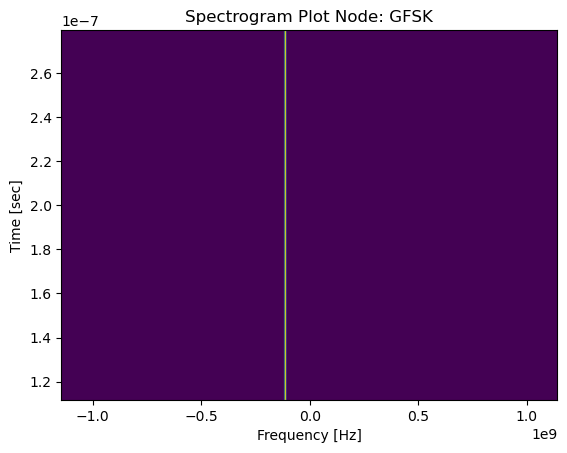

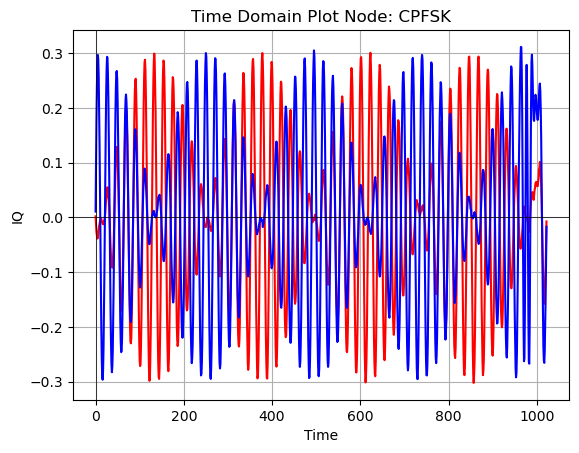

[[1.18827254e-10 2.44748130e-10 1.45361692e-10 ... 8.34482141e-12
  1.64119202e-10 1.99743170e-10]
 [6.41848777e-11 2.14697679e-10 1.40281015e-10 ... 9.06543040e-12
  1.59817232e-10 1.72800862e-10]
 [2.05837744e-12 1.80416147e-10 1.40291698e-10 ... 9.12393746e-12
  1.57780461e-10 1.37152249e-10]
 ...
 [1.09695944e-10 2.41367369e-10 1.46129206e-10 ... 9.32529871e-12
  1.64553656e-10 1.98989908e-10]
 [4.98639036e-11 1.25812581e-11 8.95379208e-11 ... 1.68046054e-10
  5.69085727e-11 1.53153473e-11]
 [3.78037555e-11 7.12660040e-12 1.60152638e-12 ... 1.66336349e-12
  9.56651787e-13 2.10416404e-11]]
(42, 32)


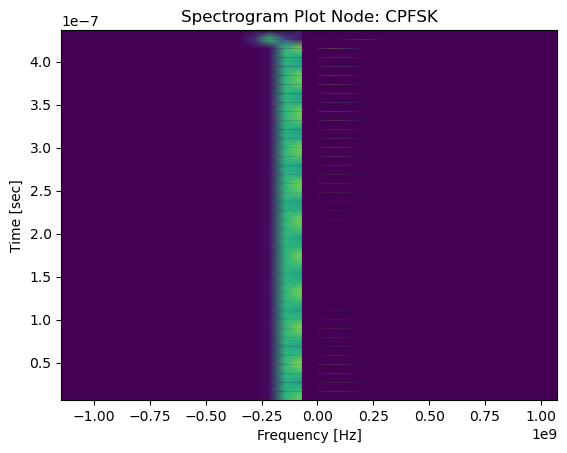

[[4.14236073e-12 9.88768223e-14 1.51985550e-10 ... 3.99183552e-10
  6.66266533e-11 3.33704817e-13]
 [1.00851413e-14 2.28366464e-13 1.53334873e-10 ... 4.03943281e-10
  6.61193539e-11 7.44478263e-14]
 [4.09652387e-12 1.15449530e-13 1.53862410e-10 ... 4.04069520e-10
  6.55884032e-11 2.60973828e-13]
 ...
 [3.25292805e-12 9.92592261e-14 1.55649069e-10 ... 3.99652305e-10
  6.42045415e-11 2.47423354e-13]
 [1.25622179e-12 2.03510796e-14 1.53947955e-10 ... 4.07857790e-10
  6.71252520e-11 5.23149887e-13]
 [4.78659333e-11 1.24011758e-10 5.88904413e-11 ... 7.13733864e-12
  9.77001426e-11 1.07523698e-10]]
(21, 64)


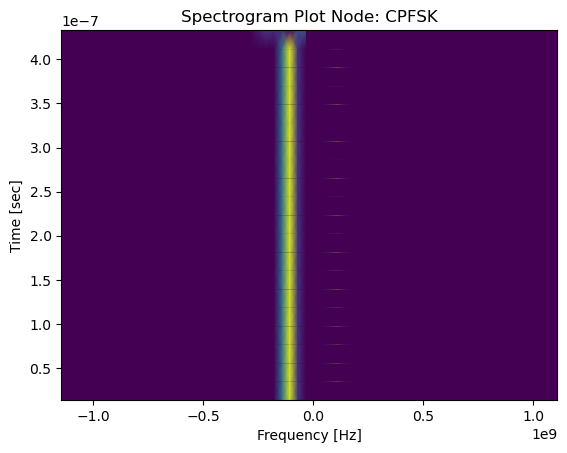

[[5.45131310e-12 1.06495049e-12 1.91073146e-14 ... 3.05424685e-14
  1.68761193e-14 1.12514176e-12]
 [5.40011615e-12 1.03388810e-12 3.59740026e-14 ... 1.16070887e-13
  1.66700546e-14 1.13260885e-12]
 [5.48330636e-12 1.04810547e-12 3.61978920e-15 ... 5.92361416e-14
  5.05457003e-15 1.01352792e-12]
 ...
 [5.58269995e-12 1.22885335e-12 7.61231468e-14 ... 4.38601351e-14
  6.06220161e-14 1.45814418e-12]
 [4.69537977e-12 1.04157653e-12 9.31727855e-15 ... 6.34772996e-14
  5.88064348e-16 7.26717950e-13]
 [5.47208370e-12 1.64002099e-12 6.47277979e-13 ... 3.89573996e-13
  1.29636331e-13 3.30828031e-12]]
(10, 128)


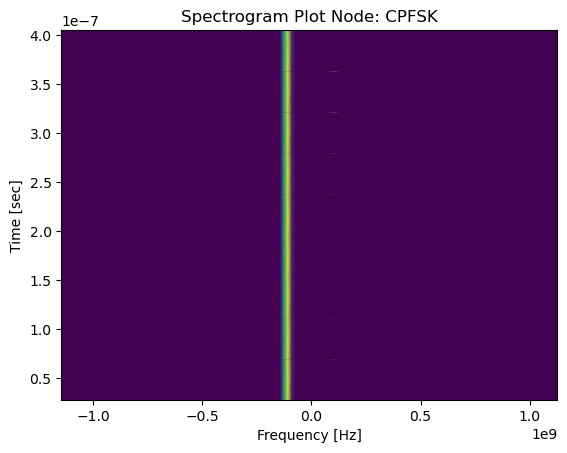

[[4.90617061e-12 1.23012256e-12 3.72837962e-15 ... 7.63390890e-16
  3.31879297e-16 1.08560471e-12]
 [4.74854186e-12 1.01794935e-12 2.74306485e-14 ... 1.12799029e-15
  3.35012402e-15 1.13300158e-12]
 [4.50047414e-12 1.13819781e-12 5.15751788e-15 ... 1.77229493e-14
  6.24245051e-16 9.07709923e-13]
 [4.78496305e-12 1.31805121e-12 5.93951516e-15 ... 1.16645258e-14
  1.95739415e-14 9.99234266e-13]
 [2.10652497e-12 5.14208673e-12 9.73723567e-13 ... 1.05751605e-12
  1.59962640e-12 6.75699103e-12]]
(5, 256)


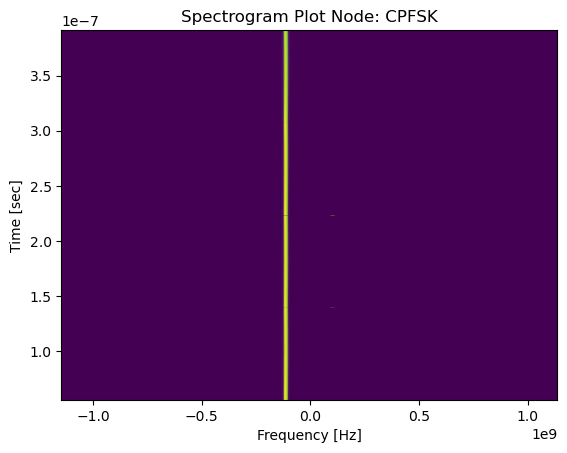

[[1.91297065e-13 1.37130056e-13 5.52128820e-15 ... 5.94754496e-15
  2.15009880e-14 8.62265156e-14]
 [1.44241087e-13 4.22648108e-14 1.45474962e-14 ... 2.40567015e-14
  3.55715419e-15 1.27519130e-13]]
(2, 512)


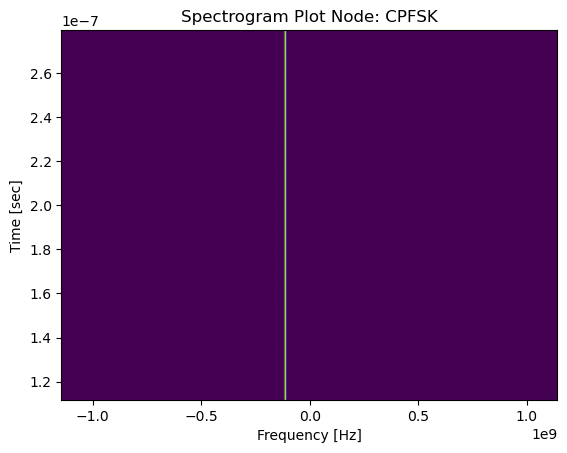

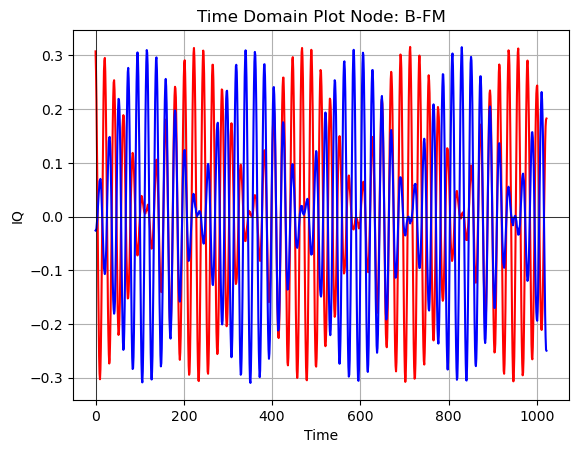

[[5.11047112e-12 1.97552803e-10 1.51672695e-10 ... 9.48438178e-12
  1.72530177e-10 1.53118983e-10]
 [8.67134140e-11 2.41487169e-10 1.55297126e-10 ... 9.11437549e-12
  1.76331100e-10 1.93908159e-10]
 [1.27892456e-10 2.67073409e-10 1.58730275e-10 ... 9.16437084e-12
  1.80024358e-10 2.20512066e-10]
 ...
 [6.84449481e-12 1.97376963e-10 1.49557478e-10 ... 1.01013753e-11
  1.71692463e-10 1.53167680e-10]
 [4.30085102e-11 2.14995664e-10 1.50081920e-10 ... 1.00702512e-11
  1.74522097e-10 1.70507399e-10]
 [1.27536035e-10 2.66923355e-10 1.57836736e-10 ... 8.67401306e-12
  1.76277831e-10 2.15455754e-10]]
(42, 32)


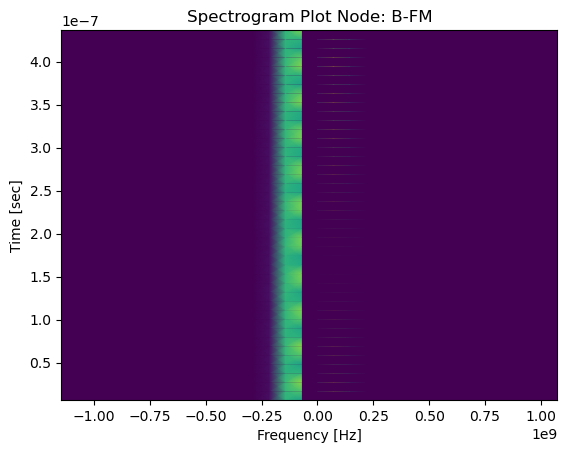

[[4.34006094e-14 2.55257698e-13 1.67956093e-10 ... 4.38056964e-10
  7.02956215e-11 1.27940311e-13]
 [4.18510213e-12 8.34909770e-14 1.67371745e-10 ... 4.36447906e-10
  7.21663378e-11 3.17623122e-13]
 [1.31172957e-13 1.98101442e-13 1.69489862e-10 ... 4.34058050e-10
  6.91761311e-11 1.13914072e-13]
 ...
 [9.64370230e-13 2.00100090e-13 1.67290942e-10 ... 4.34604620e-10
  6.89653587e-11 1.68547494e-13]
 [3.26217126e-12 2.00485536e-13 1.64439128e-10 ... 4.34211298e-10
  7.07873048e-11 2.89200172e-13]
 [1.15924431e-12 1.71444073e-13 1.68515192e-10 ... 4.31974726e-10
  6.95762862e-11 1.24345159e-13]]
(21, 64)


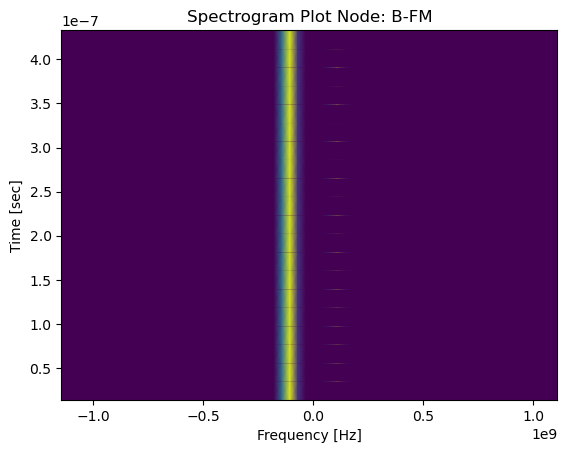

[[8.15225254e-14 1.78159007e-14 1.43027566e-14 ... 7.42908785e-14
  1.79594313e-14 1.14763144e-14]
 [1.83763233e-13 3.99984990e-14 3.63270434e-15 ... 8.44398511e-14
  8.05537012e-15 4.05125040e-14]
 [1.81248986e-13 1.66723964e-15 1.16079601e-14 ... 7.40499630e-14
  3.67989339e-15 5.43982788e-14]
 ...
 [1.15107134e-12 2.75033833e-13 7.55803128e-15 ... 3.17993241e-14
  2.10558919e-14 2.45944204e-13]
 [1.40636459e-12 4.29554417e-13 7.55696045e-14 ... 3.87802856e-14
  1.06595916e-14 2.87206282e-13]
 [1.45575316e-12 3.11368161e-13 4.62012941e-14 ... 3.17019635e-14
  2.82091553e-14 2.66038814e-13]]
(10, 128)


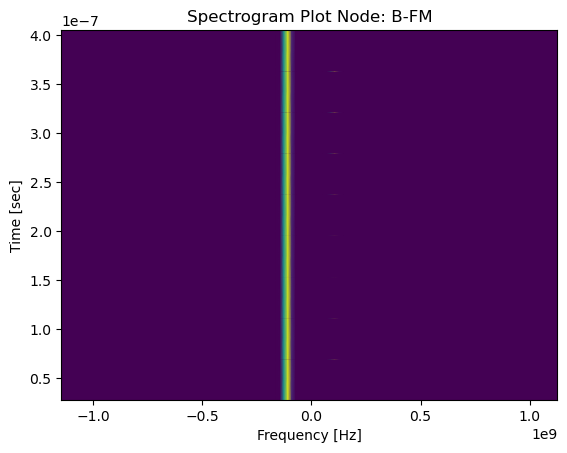

[[1.05002310e-13 1.22949688e-14 1.34864444e-14 ... 3.17659815e-15
  7.69917517e-15 3.49642286e-14]
 [3.25491769e-13 1.84054694e-13 1.57414255e-15 ... 1.31411284e-14
  3.28003134e-14 1.54249948e-14]
 [6.39249285e-13 3.11484470e-13 4.33904201e-14 ... 2.04370332e-15
  2.10316187e-16 1.11282357e-13]
 [7.69914480e-13 1.57544756e-13 2.12389543e-16 ... 4.97763494e-15
  1.61454816e-14 1.98648926e-13]
 [1.13487730e-12 2.40400955e-13 6.68713850e-15 ... 8.01902382e-15
  8.22001792e-16 2.58901857e-13]]
(5, 256)


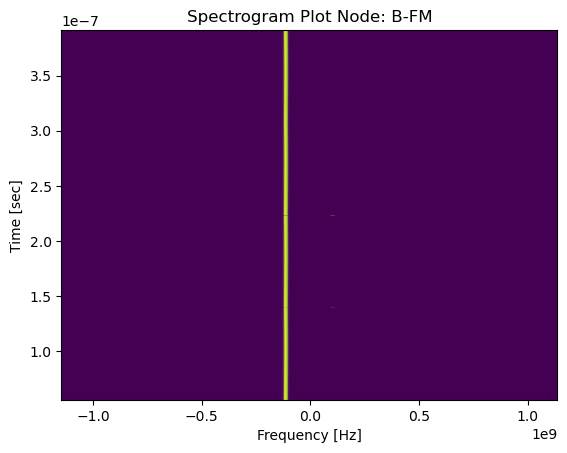

[[8.02238897e-14 5.06216124e-14 9.44612652e-14 ... 1.53572921e-14
  2.83872674e-14 5.63974856e-14]
 [1.01235947e-13 1.08899233e-14 1.71415519e-14 ... 1.06132497e-14
  2.46778839e-14 1.24187005e-13]]
(2, 512)


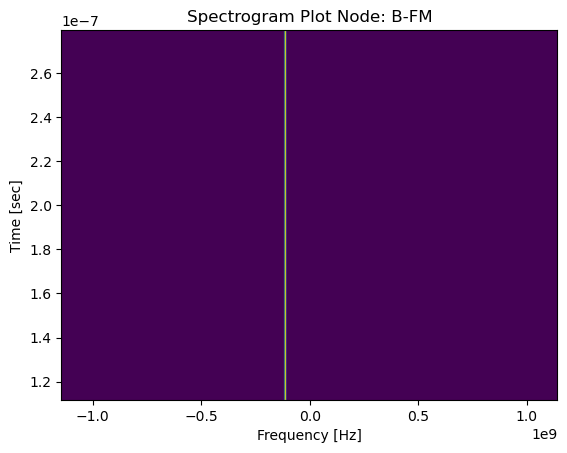

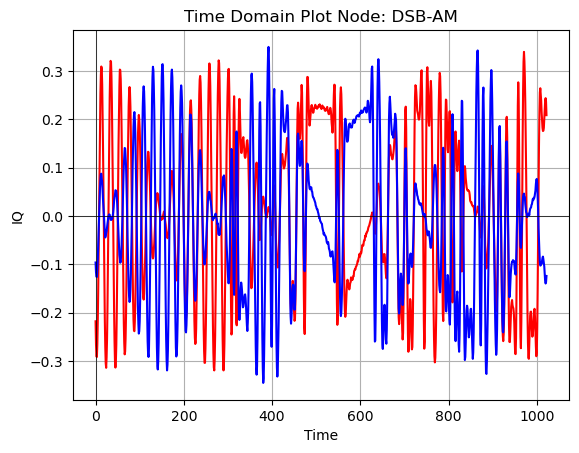

[[7.32508500e-11 2.46442580e-10 1.60472497e-10 ... 1.01481558e-11
  1.85083157e-10 1.99187155e-10]
 [2.36036495e-12 2.07669299e-10 1.60498363e-10 ... 1.02499082e-11
  1.79873225e-10 1.57597767e-10]
 [7.02145951e-11 2.42707199e-10 1.63260363e-10 ... 1.01828718e-11
  1.84751261e-10 1.91793608e-10]
 ...
 [2.47933529e-12 7.83564852e-11 9.50234764e-11 ... 5.70549782e-11
  9.60505978e-11 8.68607983e-11]
 [4.03497007e-11 2.27110877e-10 1.51827979e-10 ... 1.64380858e-11
  1.71979916e-10 2.15279828e-10]
 [1.76018425e-11 1.44501041e-10 6.78922405e-11 ... 2.30192987e-11
  8.11446599e-11 1.92560920e-10]]
(42, 32)


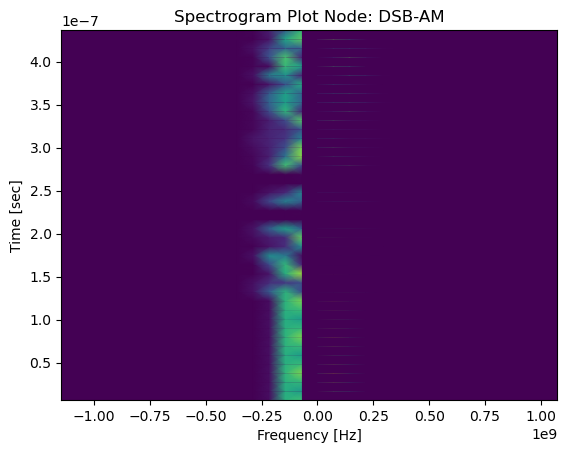

[[2.73795792e-12 3.46442443e-13 1.75849972e-10 ... 4.58003753e-10
  7.27676211e-11 2.57587566e-13]
 [2.14043743e-12 1.32764427e-13 1.77704226e-10 ... 4.58534934e-10
  7.53884953e-11 1.90888302e-13]
 [2.29602406e-12 2.23214585e-13 1.75399405e-10 ... 4.60429657e-10
  7.41917086e-11 2.28111327e-13]
 ...
 [6.72749991e-12 2.58436804e-11 1.56669834e-10 ... 3.48356478e-10
  9.54209257e-11 7.36373815e-12]
 [1.05908566e-10 9.66903143e-11 1.24817018e-10 ... 9.26575882e-11
  1.20957609e-10 1.20876456e-10]
 [1.96386609e-10 3.64176098e-10 1.02694605e-10 ... 1.11885726e-11
  2.15168800e-10 3.42642357e-10]]
(21, 64)


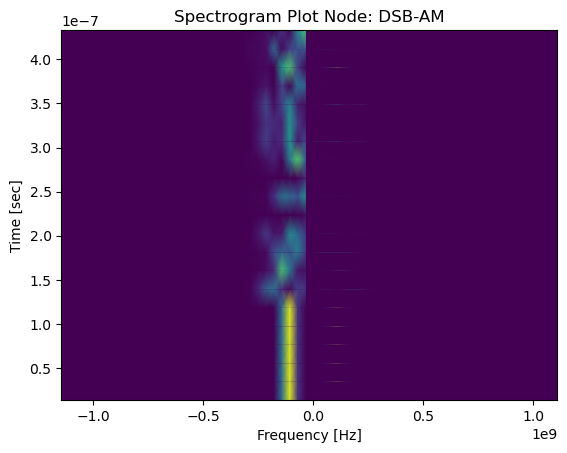

[[3.62869596e-12 7.51126638e-13 9.34125474e-15 ... 3.06684394e-14
  2.71776814e-14 7.23133133e-13]
 [3.32086764e-12 6.83848776e-13 6.38829749e-14 ... 4.82551958e-14
  3.31389376e-15 7.36882161e-13]
 [1.97062798e-12 6.84392133e-13 1.44518975e-13 ... 5.40484193e-14
  7.98432326e-14 5.93681693e-13]
 ...
 [9.10567885e-12 1.30128469e-10 1.30783239e-10 ... 6.63446975e-11
  2.04803670e-10 1.26921922e-10]
 [4.84905968e-11 1.93857954e-11 4.88466299e-11 ... 6.83583344e-11
  4.91298109e-11 1.11333546e-10]
 [2.89251917e-11 3.14136242e-11 2.90806894e-11 ... 1.82068929e-11
  6.99257467e-11 8.06163359e-11]]
(10, 128)


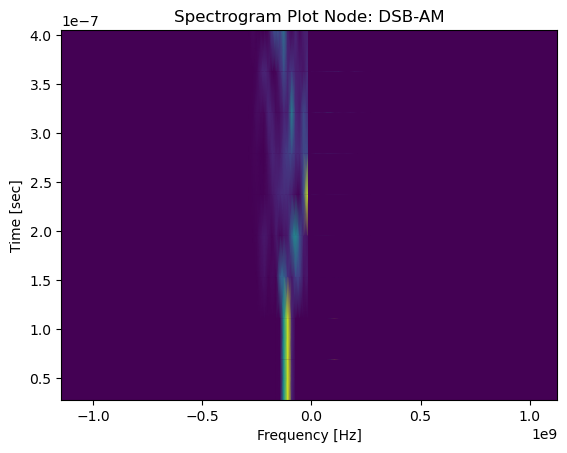

[[2.64333144e-12 5.87066821e-13 1.14438896e-15 ... 3.82725797e-15
  9.90593377e-15 6.59777285e-13]
 [4.09582639e-11 6.52918681e-11 5.15946010e-11 ... 5.28259338e-11
  9.87419198e-11 7.04796582e-11]
 [3.19250938e-10 5.62830368e-10 1.95263953e-10 ... 2.39332899e-10
  9.00497679e-10 6.89844065e-10]
 [4.30739774e-11 1.91602219e-10 8.49939424e-11 ... 8.58047689e-11
  8.25332350e-11 7.98224760e-12]
 [2.05037909e-11 1.12995493e-10 1.00033099e-10 ... 1.00933652e-10
  1.05060398e-11 8.86780006e-11]]
(5, 256)


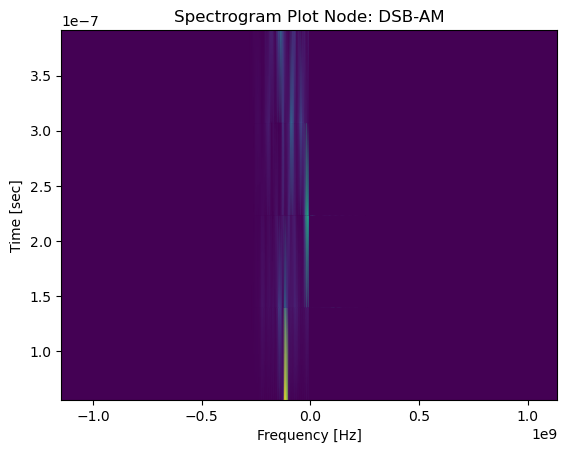

[[2.75192999e-11 7.18128122e-11 3.65169348e-11 ... 4.73508052e-11
  4.10956053e-11 3.26282324e-12]
 [1.24367219e-10 7.77829709e-10 7.63143887e-10 ... 4.73253285e-10
  2.91194769e-10 1.14981241e-10]]
(2, 512)


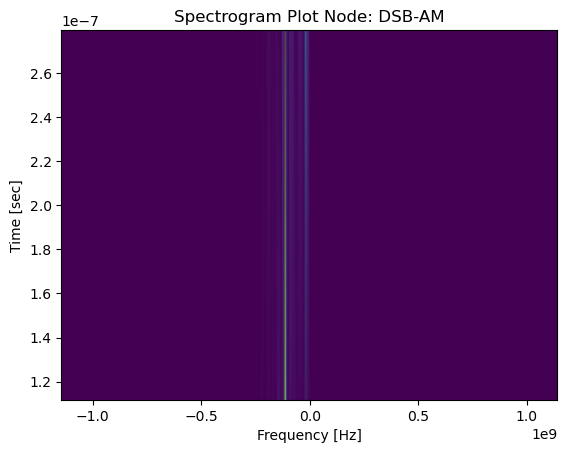

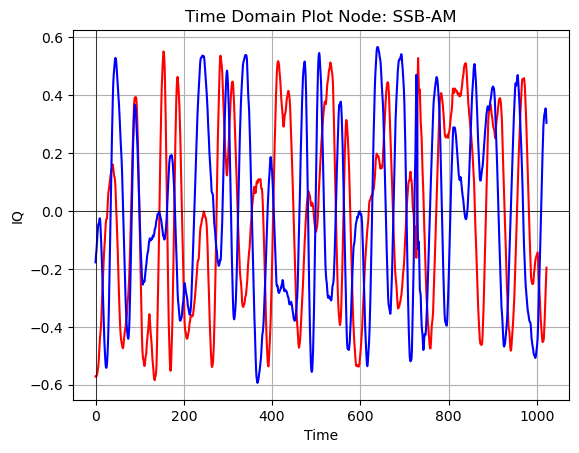

[[8.94189122e-13 2.59184548e-10 4.69956656e-11 ... 5.44579078e-16
  5.98087637e-11 2.92902659e-10]
 [2.62712403e-10 7.90645564e-10 9.70836440e-11 ... 6.38650546e-13
  4.84012857e-11 1.91489360e-10]
 [8.81221582e-11 5.74645455e-10 6.72195733e-11 ... 5.54284483e-13
  1.94355134e-11 1.02316023e-10]
 ...
 [1.36574872e-10 3.79868839e-11 8.44287562e-13 ... 1.49810245e-12
  8.51404167e-11 7.41264256e-10]
 [9.13898909e-11 5.54020989e-11 6.41447445e-12 ... 1.26666731e-12
  8.14104908e-11 6.49059364e-10]
 [9.48463885e-11 2.18680460e-10 4.47567848e-11 ... 2.27282600e-12
  2.23033072e-11 1.35175496e-10]]
(42, 32)


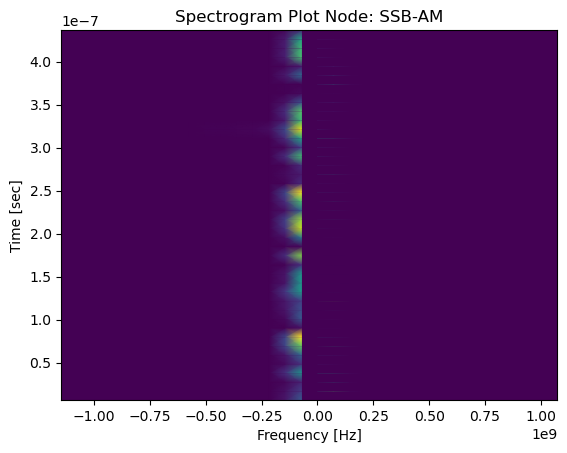

[[5.66033860e-10 3.42938905e-09 1.48224922e-09 ... 1.23113422e-10
  3.74684010e-10 1.51352801e-10]
 [2.52059017e-10 2.23496948e-09 1.53736478e-09 ... 2.38148642e-10
  6.87501019e-10 3.61951150e-10]
 [6.89055192e-10 3.45490416e-10 1.33413413e-10 ... 1.21453777e-10
  1.34939213e-10 8.76657801e-10]
 ...
 [5.90894672e-10 2.12223624e-10 3.45822233e-10 ... 9.43704660e-11
  1.04357573e-10 1.60984107e-09]
 [1.01531101e-09 5.95925370e-12 1.72395000e-13 ... 3.32022723e-12
  1.44921285e-09 4.29857169e-09]
 [9.03091449e-10 1.95865294e-10 3.07761794e-10 ... 9.85440763e-11
  5.68509305e-11 1.88637372e-09]]
(21, 64)


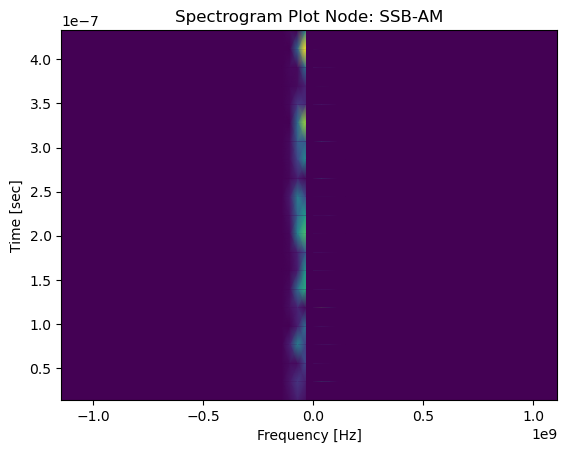

[[3.70953259e-10 2.41110148e-10 3.82285178e-09 ... 7.59726297e-10
  2.48691418e-11 2.73734950e-10]
 [5.44140214e-10 4.01046135e-10 7.86299904e-10 ... 1.80986719e-09
  4.42448008e-11 1.53657116e-09]
 [7.65616965e-10 8.78135842e-10 3.07660911e-09 ... 5.18567061e-10
  2.13090527e-10 1.62939007e-09]
 ...
 [3.35926096e-10 3.53504999e-10 2.42958908e-10 ... 2.30748429e-09
  1.86797380e-09 1.57461892e-09]
 [3.83372634e-10 1.66776135e-09 2.94825432e-10 ... 2.61154558e-10
  5.72384284e-10 5.01368517e-10]
 [4.06203076e-11 6.24050093e-11 7.77632102e-11 ... 2.59669161e-09
  6.73051976e-09 1.94714830e-09]]
(10, 128)


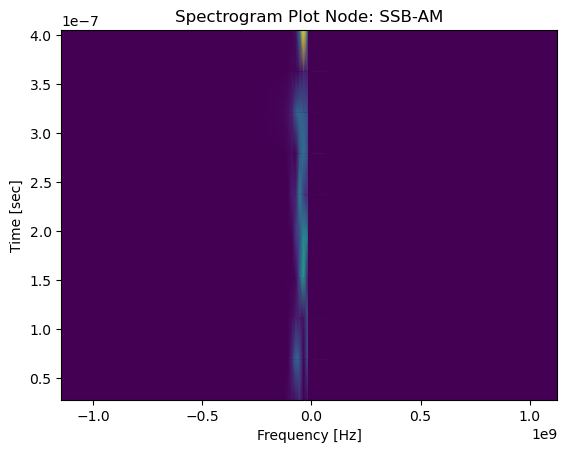

[[8.76368132e-11 3.11549540e-10 3.04156941e-10 ... 1.73441099e-09
  8.39145645e-10 1.28385409e-11]
 [4.26552743e-10 7.17101561e-10 2.24167847e-09 ... 9.69059731e-10
  2.02800877e-10 9.80367292e-10]
 [1.90030636e-10 4.30524121e-10 6.73418320e-10 ... 8.60017917e-10
  2.58162563e-09 6.71087017e-10]
 [4.07672028e-11 7.15117651e-10 1.31799486e-09 ... 1.85346023e-09
  3.15828804e-10 1.47069033e-10]
 [2.12305294e-10 1.60864394e-09 5.75292213e-10 ... 4.38326818e-09
  7.32378672e-10 1.88474842e-10]]
(5, 256)


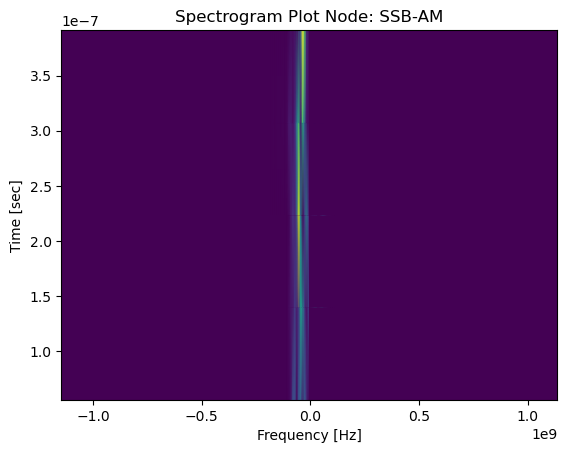

[[1.52373152e-10 3.90776178e-11 5.23268347e-10 ... 1.38801381e-09
  1.76821989e-09 1.72833440e-09]
 [1.93602983e-10 8.98923553e-11 8.24551201e-11 ... 2.20538816e-09
  6.48419269e-10 8.18282445e-10]]
(2, 512)


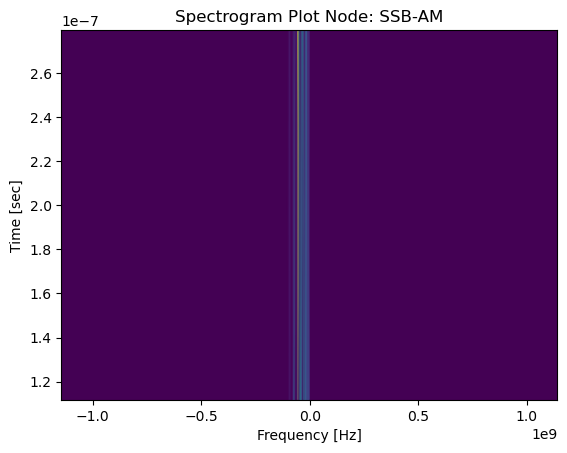

(11000,)
1


In [104]:
fs = freq = 2.29e9
# fs = samp_rate = 6e5
for TX in TXs:
    for node in RXs:
        filename = "Node_TX_"+str(TX)+"_RX_"+str(node)+"_11Modulations_"+date
        with h5py.File("data/nodes/"+filename+'.h5', 'r') as f:
            # Load the data and labels datasets.
            data = f['data'][:]
            print(data.shape)
            # print(data[0][0].shape,data[0][1].shape)
            for mod in range(len(modulations)):
                idx = mod*100
                I = data[idx][0]
                Q = data[idx][1]
                # Data in the form of two dimentional vectors of size 1024
                complexIQ = np.array(I)+np.array(Q)*1j
                plotTimeDomain(I,Q,id=modulations[mod])
                # plotConstellationDiagram(I,Q,id=modulations[mod])
                plotSpectrogram(I,Q,fs,id=modulations[mod])
            
            labels = f['labels'][:]
            print(labels.shape)
            print(labels[1099]) #Labels go from 0 to 10
            

In [94]:
len(modulations)

11